In [ ]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
# Load the data
df = pd.read_csv('stock_data.csv')

# Display the first 5 rows
display(df.head())

# Display data types
display(df.info())

# Display the number of rows and columns
display(df.shape)

,Unnamed: 0,Stock_1,Stock_2,Stock_3,Stock_4,Stock_5
0,2020-01-01,101.764052,100.160928,99.494642,99.909756,101.761266
1,2020-01-02,102.171269,99.969968,98.682973,100.640755,102.528643
2,2020-01-03,103.171258,99.575237,98.182139,100.574847,101.887811
3,2020-01-04,105.483215,99.308641,97.149381,100.925017,101.490049
4,2020-01-05,107.453175,98.188428,99.575396,101.594411,101.604283


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  365 non-null    object 
 1   Stock_1     365 non-null    float64
 2   Stock_2     365 non-null    float64
 3   Stock_3     365 non-null    float64
 4   Stock_4     365 non-null    float64
 5   Stock_5     365 non-null    float64
dtypes: float64(5), object(1)
memory usage: 17.2+ KB


None

(365, 6)

## Data preprocessing

Clean the data by handling missing values and duplicates. Ensure the date column is in the correct format and set it as the DataFrame index for time series analysis.


In [ ]:
# Convert 'Unnamed: 0' to datetime and set as index
df['Unnamed: 0'] = pd.to_datetime(df['Unnamed: 0'])
df = df.set_index('Unnamed: 0')

# Check for and remove duplicates based on index
df = df[~df.index.duplicated(keep='first')]

# Verify the index is a datetime index and the data is sorted
display(df.index)
display(df.index.is_monotonic_increasing)

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24',
               '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28',
               '2020-12-29', '2020-12-30'],
              dtype='datetime64[ns]', name='Unnamed: 0', length=365, freq=None)

True

## Exploratory data analysis (eda)

Visualize the time series data (stock prices over time). Analyze autocorrelation and seasonality using plots like lag plots, ACF, PACF, and potentially visualizations of time-based or Fourier features to gain insights into the data patterns.



Plot the time series for all stocks to visualize the stock prices over time.



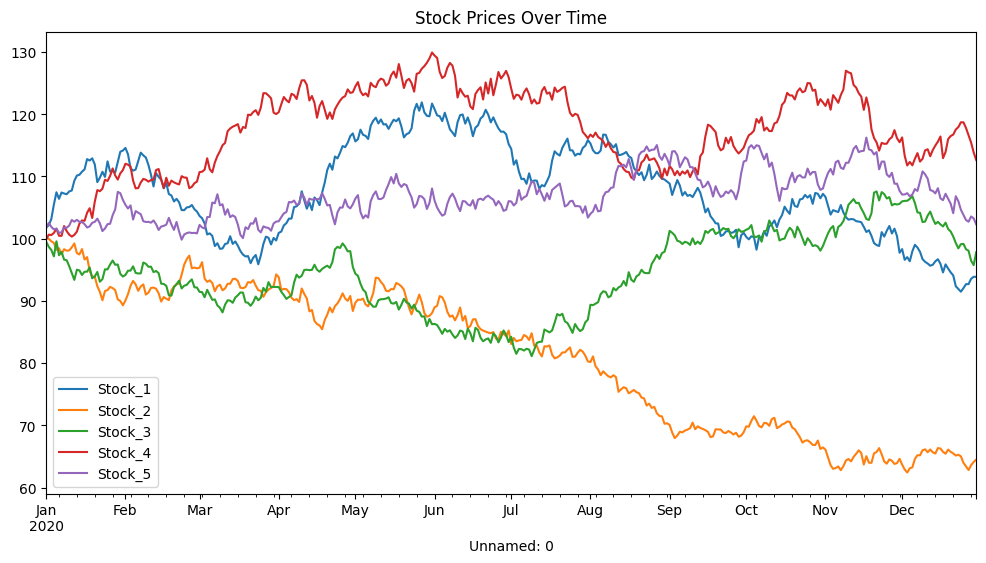

In [ ]:
df.plot(figsize=(12, 6))
plt.title("Stock Prices Over Time")
plt.show()


Create a lag plot for 'Stock_1' to visualize its autocorrelation at lag 1.



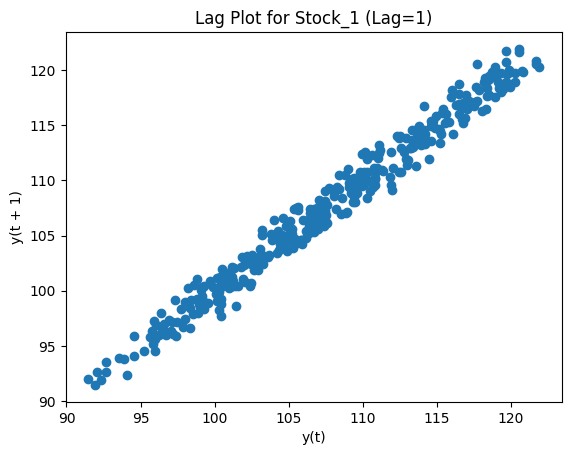

In [ ]:
pd.plotting.lag_plot(df['Stock_1'], lag=1)
plt.title("Lag Plot for Stock_1 (Lag=1)")
plt.show()


Generate ACF and PACF plots for 'Stock_1' to analyze its autocorrelation and partial autocorrelation at various lags.



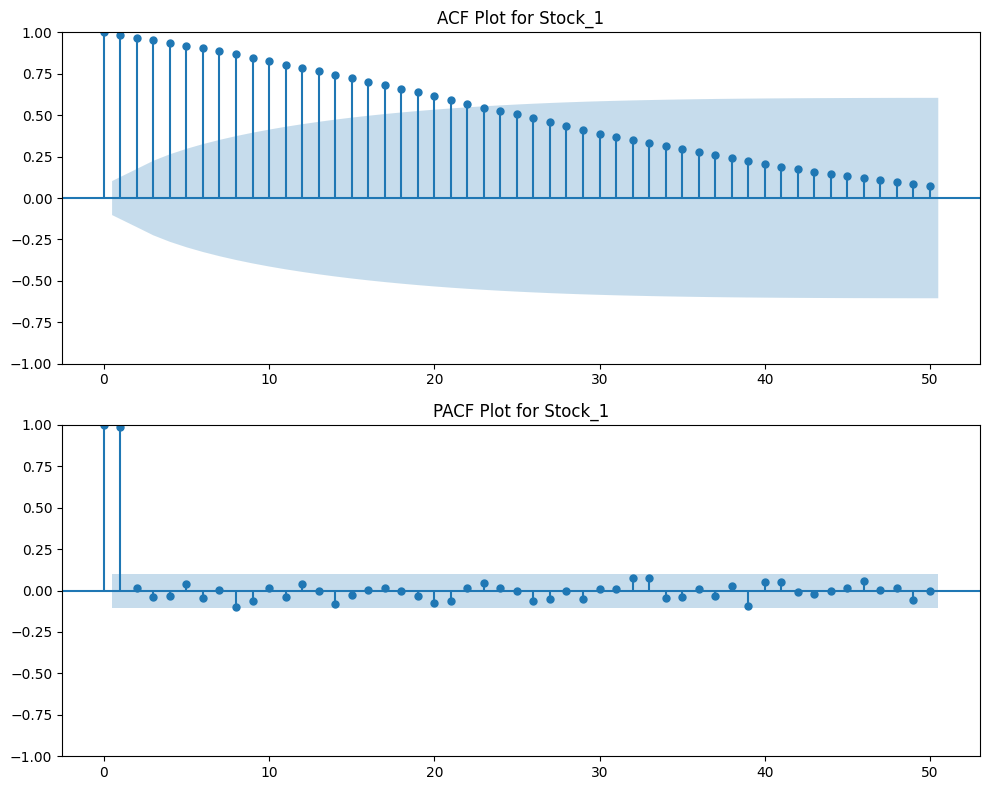

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(df['Stock_1'], lags=50, ax=axes[0])
axes[0].set_title("ACF Plot for Stock_1")
plot_pacf(df['Stock_1'], lags=50, ax=axes[1])
axes[1].set_title("PACF Plot for Stock_1")
plt.tight_layout()
plt.show()


Resample 'Stock_1' data to a weekly frequency and plot it to visualize potential seasonality.



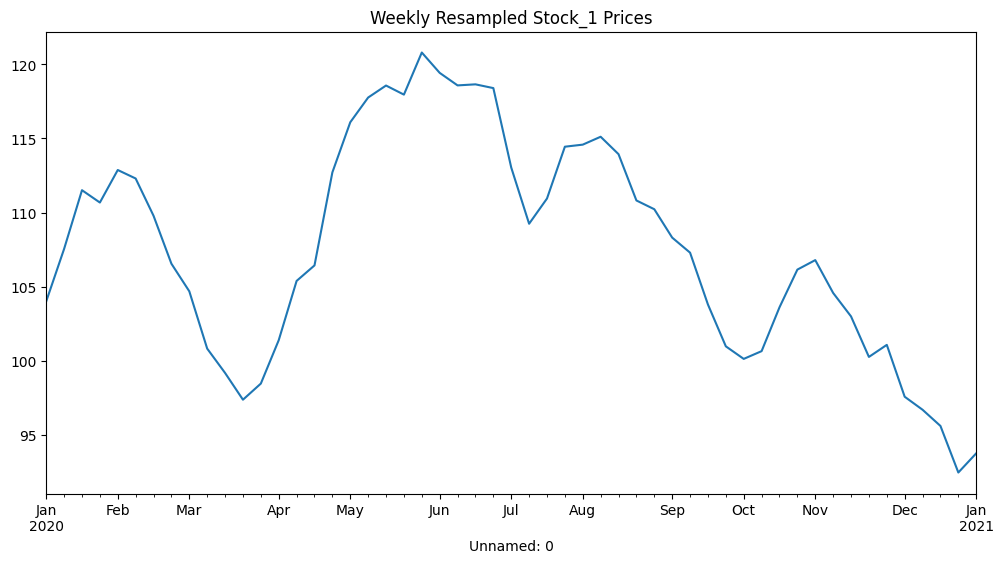

In [ ]:
df['Stock_1'].resample('W').mean().plot(figsize=(12, 6))
plt.title("Weekly Resampled Stock_1 Prices")
plt.show()

## Define metrics and baselines

Define the evaluation metrics (MAE, RMSE, MAPE) that will be used to assess model performance. Calculate the performance of simple baseline models (Naive Last-Value, Expanding Mean) to provide a benchmark for comparison with more complex models.



Import the necessary functions from sklearn.metrics and define the calculate_metrics function to compute MAE, RMSE, and MAPE.



In [ ]:


def calculate_metrics(actual, predicted):
    """Calculates MAE, RMSE, and MAPE between actual and predicted values."""
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    # Calculate MAPE, handling potential division by zero
    # Use a small epsilon to avoid division by zero for actual values close to 0
    mape = np.mean(np.abs((actual - predicted) / (actual + np.finfo(float).eps))) * 100

    return mae, rmse, mape

In [ ]:
# Calculate Naive Last-Value predictions
naive_predictions = df.shift(1)

# Calculate Expanding Mean predictions
expanding_mean_predictions = df.expanding().mean().shift(1)

# Initialize a dictionary to store the results
baseline_metrics = {}

# Calculate metrics for each stock and each baseline
for stock in df.columns:
    actual = df[stock].dropna()
    naive_pred = naive_predictions[stock].dropna()
    expanding_mean_pred = expanding_mean_predictions[stock].dropna()

    # Align actual and predicted values after dropping NaNs
    common_index_naive = actual.index.intersection(naive_pred.index)
    actual_naive = actual.loc[common_index_naive]
    naive_pred = naive_pred.loc[common_index_naive]

    common_index_expanding = actual.index.intersection(expanding_mean_pred.index)
    actual_expanding = actual.loc[common_index_expanding]
    expanding_mean_pred = expanding_mean_pred.loc[common_index_expanding]


    naive_mae, naive_rmse, naive_mape = calculate_metrics(actual_naive, naive_pred)
    expanding_mean_mae, expanding_mean_rmse, expanding_mean_mape = calculate_metrics(actual_expanding, expanding_mean_pred)

    baseline_metrics[stock] = {
        'Naive Last-Value': {'MAE': naive_mae, 'RMSE': naive_rmse, 'MAPE': naive_mape},
        'Expanding Mean': {'MAE': expanding_mean_mae, 'RMSE': expanding_mean_rmse, 'MAPE': expanding_mean_mape}
    }

# Convert the results to a DataFrame for better display
metrics_df = pd.DataFrame.from_dict({(i, j): baseline_metrics[i][j]
                                     for i in baseline_metrics.keys()
                                     for j in baseline_metrics[i].keys()},
                                    orient='index')

# Display the metrics
display(metrics_df)

MAE       RMSE       MAPE
Stock_1 Naive Last-Value  0.860176   1.062895   0.798084
        Expanding Mean    6.288524   7.424870   5.930353
Stock_2 Naive Last-Value  0.654005   0.838175   0.807716
        Expanding Mean    9.155332  11.458784  12.782605
Stock_3 Naive Last-Value  0.698883   0.886916   0.742458
        Expanding Mean    5.500038   6.535386   5.757215
Stock_4 Naive Last-Value  0.934133   1.165219   0.793964
        Expanding Mean    5.767075   6.809591   4.818617
Stock_5 Naive Last-Value  0.835471   1.055221   0.779756
        Expanding Mean    2.880122   3.771110   2.631026

## Feature engineering


Create relevant features for forecasting. This will include lag features (past values), expanding window statistics (mean, EMA, volatility) to capture trends and variability, time-based features (Day of Week, Month, Day of Year, Quarter) to capture seasonality, and Fourier features to explicitly model periodic patterns.


In [ ]:
# Define a list of stocks to process
stocks = df.columns.tolist()

# Initialize dictionaries to store modeling dataframes and feature columns for each stock
model_dfs = {}
feature_cols_dict = {}

# Define the prediction horizon
HORIZON = 1  # predict next-step target


# Create features and target for each stock
for stock in stocks:
    print(f"Creating features and target for {stock}...")

    # Use a copy of the original stock data to avoid modifying the original DataFrame
    df_numeric = df[[stock]].copy()
    TARGET_COL = stock # The target column is the stock price itself

    # Create lag features
    max_lag = 30 # Use lag up to 30 days as requested previously
    for lag in range(1, max_lag + 1):
        df_numeric[f"{TARGET_COL}_lag_{lag}"] = df_numeric[TARGET_COL].shift(lag)

    # Add Expanding Window features
    # Shift by 1 to avoid data leakage
    df_numeric[f"{TARGET_COL}_expanding_mean"] = df_numeric[TARGET_COL].expanding().mean().shift(1)
    df_numeric[f"{TARGET_COL}_expanding_ema"] = df_numeric[TARGET_COL].ewm(alpha=0.05, adjust=False).mean().shift(1)
    df_numeric[f"{TARGET_COL}_expanding_vol"] = df_numeric[TARGET_COL].pct_change().expanding().std().shift(1)


    # Add Time-Based features
    df_numeric['Day_of_Week'] = df_numeric.index.dayofweek
    df_numeric['Day_of_Year'] = df_numeric.index.dayofyear
    df_numeric['Month'] = df_numeric.index.month
    df_numeric['Quarter'] = df_numeric.index.quarter


    # Add Fourier features for potential seasonality (e.g., weekly, yearly)
    time_index = np.arange(len(df_numeric))
    periods = [7, 365.25] # Weekly and yearly periods

    for period in periods:
        df_numeric[f'{TARGET_COL}_sin_{int(period)}d'] = np.sin(2 * np.pi * time_index / period)
        df_numeric[f'{TARGET_COL}_cos_{int(period)}d'] = np.cos(2 * np.pi * time_index / period)


    # Define supervised target: next-step value (direct forecasting)
    df_numeric["y"] = df_numeric[TARGET_COL].shift(-HORIZON)

    # Define feature columns - exclude the original target column and the new 'y' target column
    feature_cols = [c for c in df_numeric.columns if c != "y" and c != TARGET_COL]


    # Drop rows with any NA in features/target
    model_df = df_numeric[feature_cols + ["y"]].dropna().copy()

    # Store the modeling dataframe and feature columns
    model_dfs[stock] = model_df
    feature_cols_dict[stock] = feature_cols


    print(f"Modeling frame shape for {stock}: {model_df.shape}")
    print(f"Features used for {stock}: {feature_cols}")
    print(f"First 5 rows of modeling data for {stock}:")
    display(model_df.head())

print("\nFeature engineering and target definition complete for all stocks.")

Creating features and target for Stock_1...
Modeling frame shape for Stock_1: (334, 42)
Features used for Stock_1: ['Stock_1_lag_1', 'Stock_1_lag_2', 'Stock_1_lag_3', 'Stock_1_lag_4', 'Stock_1_lag_5', 'Stock_1_lag_6', 'Stock_1_lag_7', 'Stock_1_lag_8', 'Stock_1_lag_9', 'Stock_1_lag_10', 'Stock_1_lag_11', 'Stock_1_lag_12', 'Stock_1_lag_13', 'Stock_1_lag_14', 'Stock_1_lag_15', 'Stock_1_lag_16', 'Stock_1_lag_17', 'Stock_1_lag_18', 'Stock_1_lag_19', 'Stock_1_lag_20', 'Stock_1_lag_21', 'Stock_1_lag_22', 'Stock_1_lag_23', 'Stock_1_lag_24', 'Stock_1_lag_25', 'Stock_1_lag_26', 'Stock_1_lag_27', 'Stock_1_lag_28', 'Stock_1_lag_29', 'Stock_1_lag_30', 'Stock_1_expanding_mean', 'Stock_1_expanding_ema', 'Stock_1_expanding_vol', 'Day_of_Week', 'Day_of_Year', 'Month', 'Quarter', 'Stock_1_sin_7d', 'Stock_1_cos_7d', 'Stock_1_sin_365d', 'Stock_1_cos_365d']
First 5 rows of modeling data for Stock_1:


,Stock_1_lag_1,Stock_1_lag_2,Stock_1_lag_3,Stock_1_lag_4,Stock_1_lag_5,Stock_1_lag_6,Stock_1_lag_7,Stock_1_lag_8,Stock_1_lag_9,Stock_1_lag_10,...,Stock_1_expanding_vol,Day_of_Week,Day_of_Year,Month,Quarter,Stock_1_sin_7d,Stock_1_cos_7d,Stock_1_sin_365d,Stock_1_cos_365d,y
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2020-01-31,113.975896,112.325433,110.629723,110.837193,110.786498,112.421518,109.926458,110.748393,109.799249,109.086241,...,0.010906,4,31,1,1,0.974928,-0.222521,0.493468,0.869764,114.584181
2020-02-01,114.152499,113.975896,112.325433,110.629723,110.837193,110.786498,112.421518,109.926458,110.748393,109.799249,...,0.010726,5,32,2,1,0.433884,-0.900969,0.508356,0.861147,113.566919
2020-02-02,114.584181,114.152499,113.975896,112.325433,110.629723,110.837193,110.786498,112.421518,109.926458,110.748393,...,0.010545,6,33,2,1,-0.433884,-0.900969,0.523094,0.852275,111.317390
2020-02-03,113.566919,114.584181,114.152499,113.975896,112.325433,110.629723,110.837193,110.786498,112.421518,109.926458,...,0.010617,0,34,2,1,-0.974928,-0.222521,0.537677,0.843151,110.930103
2020-02-04,111.317390,113.566919,114.584181,114.152499,113.975896,112.325433,110.629723,110.837193,110.786498,112.421518,...,0.011209,1,35,2,1,-0.781831,0.623490,0.552101,0.833777,111.103541


Creating features and target for Stock_2...
Modeling frame shape for Stock_2: (334, 42)
Features used for Stock_2: ['Stock_2_lag_1', 'Stock_2_lag_2', 'Stock_2_lag_3', 'Stock_2_lag_4', 'Stock_2_lag_5', 'Stock_2_lag_6', 'Stock_2_lag_7', 'Stock_2_lag_8', 'Stock_2_lag_9', 'Stock_2_lag_10', 'Stock_2_lag_11', 'Stock_2_lag_12', 'Stock_2_lag_13', 'Stock_2_lag_14', 'Stock_2_lag_15', 'Stock_2_lag_16', 'Stock_2_lag_17', 'Stock_2_lag_18', 'Stock_2_lag_19', 'Stock_2_lag_20', 'Stock_2_lag_21', 'Stock_2_lag_22', 'Stock_2_lag_23', 'Stock_2_lag_24', 'Stock_2_lag_25', 'Stock_2_lag_26', 'Stock_2_lag_27', 'Stock_2_lag_28', 'Stock_2_lag_29', 'Stock_2_lag_30', 'Stock_2_expanding_mean', 'Stock_2_expanding_ema', 'Stock_2_expanding_vol', 'Day_of_Week', 'Day_of_Year', 'Month', 'Quarter', 'Stock_2_sin_7d', 'Stock_2_cos_7d', 'Stock_2_sin_365d', 'Stock_2_cos_365d']
First 5 rows of modeling data for Stock_2:


,Stock_2_lag_1,Stock_2_lag_2,Stock_2_lag_3,Stock_2_lag_4,Stock_2_lag_5,Stock_2_lag_6,Stock_2_lag_7,Stock_2_lag_8,Stock_2_lag_9,Stock_2_lag_10,...,Stock_2_expanding_vol,Day_of_Week,Day_of_Year,Month,Quarter,Stock_2_sin_7d,Stock_2_cos_7d,Stock_2_sin_365d,Stock_2_cos_365d,y
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2020-01-31,89.975473,90.238823,91.721477,92.046800,92.252222,91.731837,91.581435,90.096522,91.442404,92.352548,...,0.009343,4,31,1,1,0.974928,-0.222521,0.493468,0.869764,90.056359
2020-02-01,89.290316,89.975473,90.238823,91.721477,92.046800,92.252222,91.731837,91.581435,90.096522,91.442404,...,0.009209,5,32,2,1,0.433884,-0.900969,0.508356,0.861147,91.083994
2020-02-02,90.056359,89.290316,89.975473,90.238823,91.721477,92.046800,92.252222,91.731837,91.581435,90.096522,...,0.009323,6,33,2,1,-0.433884,-0.900969,0.523094,0.852275,92.419813
2020-02-03,91.083994,90.056359,89.290316,89.975473,90.238823,91.721477,92.046800,92.252222,91.731837,91.581435,...,0.009537,0,34,2,1,-0.974928,-0.222521,0.537677,0.843151,93.207739
2020-02-04,92.419813,91.083994,90.056359,89.290316,89.975473,90.238823,91.721477,92.046800,92.252222,91.731837,...,0.009873,1,35,2,1,-0.781831,0.623490,0.552101,0.833777,92.649748


Creating features and target for Stock_3...
Modeling frame shape for Stock_3: (334, 42)
Features used for Stock_3: ['Stock_3_lag_1', 'Stock_3_lag_2', 'Stock_3_lag_3', 'Stock_3_lag_4', 'Stock_3_lag_5', 'Stock_3_lag_6', 'Stock_3_lag_7', 'Stock_3_lag_8', 'Stock_3_lag_9', 'Stock_3_lag_10', 'Stock_3_lag_11', 'Stock_3_lag_12', 'Stock_3_lag_13', 'Stock_3_lag_14', 'Stock_3_lag_15', 'Stock_3_lag_16', 'Stock_3_lag_17', 'Stock_3_lag_18', 'Stock_3_lag_19', 'Stock_3_lag_20', 'Stock_3_lag_21', 'Stock_3_lag_22', 'Stock_3_lag_23', 'Stock_3_lag_24', 'Stock_3_lag_25', 'Stock_3_lag_26', 'Stock_3_lag_27', 'Stock_3_lag_28', 'Stock_3_lag_29', 'Stock_3_lag_30', 'Stock_3_expanding_mean', 'Stock_3_expanding_ema', 'Stock_3_expanding_vol', 'Day_of_Week', 'Day_of_Year', 'Month', 'Quarter', 'Stock_3_sin_7d', 'Stock_3_cos_7d', 'Stock_3_sin_365d', 'Stock_3_cos_365d']
First 5 rows of modeling data for Stock_3:


,Stock_3_lag_1,Stock_3_lag_2,Stock_3_lag_3,Stock_3_lag_4,Stock_3_lag_5,Stock_3_lag_6,Stock_3_lag_7,Stock_3_lag_8,Stock_3_lag_9,Stock_3_lag_10,...,Stock_3_expanding_vol,Day_of_Week,Day_of_Year,Month,Quarter,Stock_3_sin_7d,Stock_3_cos_7d,Stock_3_sin_365d,Stock_3_cos_365d,y
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2020-01-31,94.338352,95.840162,95.802065,96.484699,95.842011,95.061173,95.075299,93.489547,93.072401,94.645021,...,0.011416,4,31,1,1,0.974928,-0.222521,0.493468,0.869764,94.162114
2020-02-01,93.912600,94.338352,95.840162,95.802065,96.484699,95.842011,95.061173,95.075299,93.489547,93.072401,...,0.011228,5,32,2,1,0.433884,-0.900969,0.508356,0.861147,94.843001
2020-02-02,94.162114,93.912600,94.338352,95.840162,95.802065,96.484699,95.842011,95.061173,95.075299,93.489547,...,0.011069,6,33,2,1,-0.433884,-0.900969,0.523094,0.852275,94.866344
2020-02-03,94.843001,94.162114,93.912600,94.338352,95.840162,95.802065,96.484699,95.842011,95.061173,95.075299,...,0.011004,0,34,2,1,-0.974928,-0.222521,0.537677,0.843151,95.549366
2020-02-04,94.866344,94.843001,94.162114,93.912600,94.338352,95.840162,95.802065,96.484699,95.842011,95.061173,...,0.010834,1,35,2,1,-0.781831,0.623490,0.552101,0.833777,94.495546


Creating features and target for Stock_4...
Modeling frame shape for Stock_4: (334, 42)
Features used for Stock_4: ['Stock_4_lag_1', 'Stock_4_lag_2', 'Stock_4_lag_3', 'Stock_4_lag_4', 'Stock_4_lag_5', 'Stock_4_lag_6', 'Stock_4_lag_7', 'Stock_4_lag_8', 'Stock_4_lag_9', 'Stock_4_lag_10', 'Stock_4_lag_11', 'Stock_4_lag_12', 'Stock_4_lag_13', 'Stock_4_lag_14', 'Stock_4_lag_15', 'Stock_4_lag_16', 'Stock_4_lag_17', 'Stock_4_lag_18', 'Stock_4_lag_19', 'Stock_4_lag_20', 'Stock_4_lag_21', 'Stock_4_lag_22', 'Stock_4_lag_23', 'Stock_4_lag_24', 'Stock_4_lag_25', 'Stock_4_lag_26', 'Stock_4_lag_27', 'Stock_4_lag_28', 'Stock_4_lag_29', 'Stock_4_lag_30', 'Stock_4_expanding_mean', 'Stock_4_expanding_ema', 'Stock_4_expanding_vol', 'Day_of_Week', 'Day_of_Year', 'Month', 'Quarter', 'Stock_4_sin_7d', 'Stock_4_cos_7d', 'Stock_4_sin_365d', 'Stock_4_cos_365d']
First 5 rows of modeling data for Stock_4:


,Stock_4_lag_1,Stock_4_lag_2,Stock_4_lag_3,Stock_4_lag_4,Stock_4_lag_5,Stock_4_lag_6,Stock_4_lag_7,Stock_4_lag_8,Stock_4_lag_9,Stock_4_lag_10,...,Stock_4_expanding_vol,Day_of_Week,Day_of_Year,Month,Quarter,Stock_4_sin_7d,Stock_4_cos_7d,Stock_4_sin_365d,Stock_4_cos_365d,y
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2020-01-31,110.502063,109.493184,110.156693,111.286052,110.070240,109.272169,109.460661,108.029957,107.623238,107.804580,...,0.009307,4,31,1,1,0.974928,-0.222521,0.493468,0.869764,112.036791
2020-02-01,111.011273,110.502063,109.493184,110.156693,111.286052,110.070240,109.272169,109.460661,108.029957,107.623238,...,0.009148,5,32,2,1,0.433884,-0.900969,0.508356,0.861147,111.888266
2020-02-02,112.036791,111.011273,110.502063,109.493184,110.156693,111.286052,110.070240,109.272169,109.460661,108.029957,...,0.009052,6,33,2,1,-0.433884,-0.900969,0.523094,0.852275,111.564903
2020-02-03,111.888266,112.036791,111.011273,110.502063,109.493184,110.156693,111.286052,110.070240,109.272169,109.460661,...,0.008949,0,34,2,1,-0.974928,-0.222521,0.537677,0.843151,109.335123
2020-02-04,111.564903,111.888266,112.036791,111.011273,110.502063,109.493184,110.156693,111.286052,110.070240,109.272169,...,0.008880,1,35,2,1,-0.781831,0.623490,0.552101,0.833777,108.082142


Creating features and target for Stock_5...
Modeling frame shape for Stock_5: (334, 42)
Features used for Stock_5: ['Stock_5_lag_1', 'Stock_5_lag_2', 'Stock_5_lag_3', 'Stock_5_lag_4', 'Stock_5_lag_5', 'Stock_5_lag_6', 'Stock_5_lag_7', 'Stock_5_lag_8', 'Stock_5_lag_9', 'Stock_5_lag_10', 'Stock_5_lag_11', 'Stock_5_lag_12', 'Stock_5_lag_13', 'Stock_5_lag_14', 'Stock_5_lag_15', 'Stock_5_lag_16', 'Stock_5_lag_17', 'Stock_5_lag_18', 'Stock_5_lag_19', 'Stock_5_lag_20', 'Stock_5_lag_21', 'Stock_5_lag_22', 'Stock_5_lag_23', 'Stock_5_lag_24', 'Stock_5_lag_25', 'Stock_5_lag_26', 'Stock_5_lag_27', 'Stock_5_lag_28', 'Stock_5_lag_29', 'Stock_5_lag_30', 'Stock_5_expanding_mean', 'Stock_5_expanding_ema', 'Stock_5_expanding_vol', 'Day_of_Week', 'Day_of_Year', 'Month', 'Quarter', 'Stock_5_sin_7d', 'Stock_5_cos_7d', 'Stock_5_sin_365d', 'Stock_5_cos_365d']
First 5 rows of modeling data for Stock_5:


,Stock_5_lag_1,Stock_5_lag_2,Stock_5_lag_3,Stock_5_lag_4,Stock_5_lag_5,Stock_5_lag_6,Stock_5_lag_7,Stock_5_lag_8,Stock_5_lag_9,Stock_5_lag_10,...,Stock_5_expanding_vol,Day_of_Week,Day_of_Year,Month,Quarter,Stock_5_sin_7d,Stock_5_cos_7d,Stock_5_sin_365d,Stock_5_cos_365d,y
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2020-01-31,107.299219,107.515118,104.708337,103.766450,102.386247,102.335225,101.636090,101.213983,102.447176,103.208786,...,0.007520,4,31,1,1,0.974928,-0.222521,0.493468,0.869764,105.441233
2020-02-01,106.227462,107.299219,107.515118,104.708337,103.766450,102.386247,102.335225,101.636090,101.213983,102.447176,...,0.007699,5,32,2,1,0.433884,-0.900969,0.508356,0.861147,104.844965
2020-02-02,105.441233,106.227462,107.299219,107.515118,104.708337,103.766450,102.386247,102.335225,101.636090,101.213983,...,0.007735,6,33,2,1,-0.433884,-0.900969,0.523094,0.852275,105.344060
2020-02-03,104.844965,105.441233,106.227462,107.299219,107.515118,104.708337,103.766450,102.386247,102.335225,101.636090,...,0.007704,0,34,2,1,-0.974928,-0.222521,0.537677,0.843151,103.070663
2020-02-04,105.344060,104.844965,105.441233,106.227462,107.299219,107.515118,104.708337,103.766450,102.386247,102.335225,...,0.007612,1,35,2,1,-0.781831,0.623490,0.552101,0.833777,104.429702



Feature engineering and target definition complete for all stocks.


## Data splitting

Split the data chronologically into training, validation, and test sets. This ensures that the model is evaluated on unseen future data, simulating a real-world forecasting scenario.


In [ ]:
# Define split points (e.g., 70% train, 15% validation, 15% test)
train_size_ratio = 0.7
val_size_ratio = 0.15
# test_size_ratio = 0.15 # The rest will be test size

# Initialize dictionaries to store the splits
X_train = {}
X_val = {}
X_test = {}
y_train = {}
y_val = {}
y_test = {}

# Iterate through each stock and perform the split
for stock in stocks:
    print(f"Splitting data for {stock}...")

    # Get the modeling dataframe for the current stock from model_dfs
    model_df_stock = model_dfs[stock].copy()

    # Separate features (X) and target (y)
    X = model_df_stock.drop(columns=['y'])
    y = model_df_stock['y']

    # Calculate the actual split sizes based on the cleaned data length
    total_size = len(model_df_stock)
    train_size = int(total_size * train_size_ratio)
    val_size = int(total_size * val_size_ratio)
    test_size = total_size - train_size - val_size

    # Split the data chronologically
    X_train[stock] = X.iloc[:train_size]
    X_val[stock] = X.iloc[train_size:train_size + val_size]
    X_test[stock] = X.iloc[train_size + val_size:]

    y_train[stock] = y.iloc[:train_size]
    y_val[stock] = y.iloc[train_size:train_size + val_size]
    y_test[stock] = y.iloc[train_size + val_size:]

# Display the shapes of the splits for one stock as an example
stock_example = stocks[0]
print(f"\nShapes of splits for {stock_example}:")
print("X_train shape:", X_train[stock_example].shape)
print("X_val shape:", X_val[stock_example].shape)
print("X_test shape:", X_test[stock_example].shape)
print("y_train shape:", y_train[stock_example].shape)
print("y_val shape:", y_val[stock_example].shape)
print("y_test shape:", y_test[stock_example].shape)

Splitting data for Stock_1...
Splitting data for Stock_2...
Splitting data for Stock_3...
Splitting data for Stock_4...
Splitting data for Stock_5...

Shapes of splits for Stock_1:
X_train shape: (233, 41)
X_val shape: (50, 41)
X_test shape: (51, 41)
y_train shape: (233,)
y_val shape: (50,)
y_test shape: (51,)


## Model selection and training

Train several forecasting models, including regression models (like Linear Regression, Ridge, Gradient Boosting) and potentially time series-specific models if desired. Tune hyperparameters using the validation set to optimize model performance.


In [ ]:
# Initialize dictionaries to store models and validation metrics
trained_models = {}
validation_metrics = {}

# Define the models to train
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'GradientBoostingRegressor': GradientBoostingRegressor()
}

# Train and evaluate each model for each stock
for stock in stocks:
    print(f"Training models for {stock}...")
    trained_models[stock] = {}
    validation_metrics[stock] = {}

    for model_name, model in models.items():
        print(f"  Training {model_name} for {stock}...")
        # Train the model
        model.fit(X_train[stock], y_train[stock])
        trained_models[stock][model_name] = model

        # Make predictions on the validation set
        predictions = model.predict(X_val[stock])

        # Evaluate the model
        mae, rmse, mape = calculate_metrics(y_val[stock], predictions)
        validation_metrics[stock][model_name] = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

        print(f"    Validation Metrics for {model_name}: MAE={mae:.4f}, RMSE={rmse:.4f}, MAPE={mape:.4f}")

# Identify the best performing model for each stock based on RMSE
best_models = {}
for stock in stocks:
    best_model_name = min(validation_metrics[stock], key=lambda k: validation_metrics[stock][k]['RMSE'])
    best_models[stock] = trained_models[stock][best_model_name]
    print(f"\nBest model for {stock} based on validation RMSE: {best_model_name}")

# At this point, you could add hyperparameter tuning for the best models if desired.
# For this task, we will proceed with the identified best models without further tuning.

# Store the trained best models
final_models = best_models

# Display the validation metrics for all models and stocks
validation_metrics_df = pd.DataFrame.from_dict({(i, j): validation_metrics[i][j]
                                               for i in validation_metrics.keys()
                                               for j in validation_metrics[i].keys()},
                                              orient='index')
display(validation_metrics_df)

Training models for Stock_1...
  Training LinearRegression for Stock_1...
    Validation Metrics for LinearRegression: MAE=4.7188, RMSE=5.3772, MAPE=4.5175
  Training Ridge for Stock_1...
    Validation Metrics for Ridge: MAE=1.6110, RMSE=1.8532, MAPE=1.5527
  Training GradientBoostingRegressor for Stock_1...
    Validation Metrics for GradientBoostingRegressor: MAE=1.4162, RMSE=1.6705, MAPE=1.3700
Training models for Stock_2...
  Training LinearRegression for Stock_2...
    Validation Metrics for LinearRegression: MAE=8.1544, RMSE=9.4374, MAPE=12.1501
  Training Ridge for Stock_2...
    Validation Metrics for Ridge: MAE=2.4032, RMSE=2.7133, MAPE=3.5307
  Training GradientBoostingRegressor for Stock_2...
    Validation Metrics for GradientBoostingRegressor: MAE=2.0873, RMSE=2.9005, MAPE=3.1614
Training models for Stock_3...
  Training LinearRegression for Stock_3...
    Validation Metrics for LinearRegression: MAE=7.4194, RMSE=9.3287, MAPE=7.3523
  Training Ridge for Stock_3...
    Val

MAE       RMSE       MAPE
Stock_1 LinearRegression            4.718825   5.377156   4.517463
        Ridge                       1.611017   1.853246   1.552659
        GradientBoostingRegressor   1.416240   1.670527   1.370001
Stock_2 LinearRegression            8.154443   9.437398  12.150087
        Ridge                       2.403173   2.713278   3.530678
        GradientBoostingRegressor   2.087278   2.900523   3.161441
Stock_3 LinearRegression            7.419377   9.328658   7.352301
        Ridge                       1.652364   2.128405   1.632579
        GradientBoostingRegressor   1.039451   1.376078   1.033953
Stock_4 LinearRegression           18.745678  22.609710  15.360804
        Ridge                       1.539373   1.945960   1.279553
        GradientBoostingRegressor   1.628809   1.985908   1.347411
Stock_5 LinearRegression            4.107415   4.597376   3.701687
        Ridge                       1.688020   2.092501   1.524905
        GradientBoostingRegressor   1.806304   2.296986   1.620416

## Model evaluation

Evaluate the best-performing model on the held-out test set using the defined metrics. Compare the model's performance to the baselines to determine its effectiveness.


Regenerating features and splitting data for Stock_1...
Regenerating features and splitting data for Stock_2...
Regenerating features and splitting data for Stock_3...
Regenerating features and splitting data for Stock_4...
Regenerating features and splitting data for Stock_5...
Training models for Stock_1...
  Training LinearRegression for Stock_1...
    Validation Metrics for LinearRegression: MAE=1.6662, RMSE=1.9093, MAPE=1.6176
  Training Ridge for Stock_1...
    Validation Metrics for Ridge: MAE=2.1563, RMSE=2.4480, MAPE=2.0830
  Training GradientBoostingRegressor for Stock_1...
    Validation Metrics for GradientBoostingRegressor: MAE=1.1175, RMSE=1.3796, MAPE=1.0819

Best model for Stock_1 based on validation RMSE: GradientBoostingRegressor
Training models for Stock_2...
  Training LinearRegression for Stock_2...
    Validation Metrics for LinearRegression: MAE=5.5392, RMSE=6.4248, MAPE=8.1407
  Training Ridge for Stock_2...
    Validation Metrics for Ridge: MAE=1.1948, RMSE=1.4

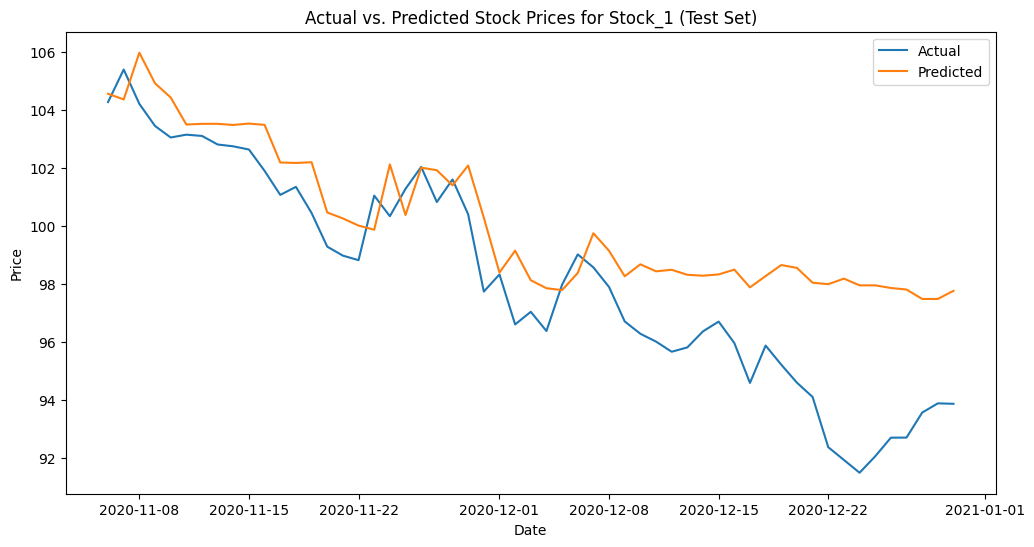

Plotting actual vs predicted for Stock_2 on test set...


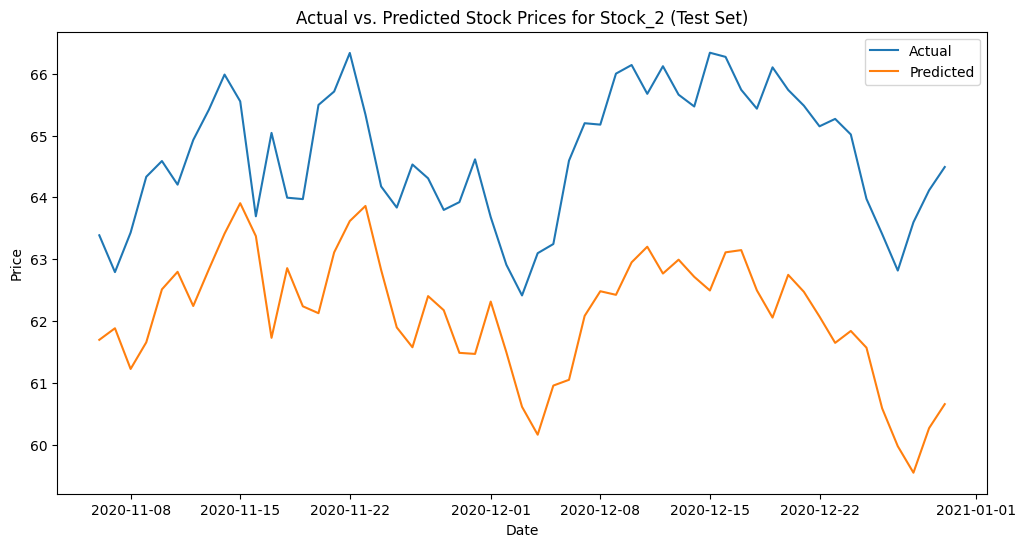

Plotting actual vs predicted for Stock_3 on test set...


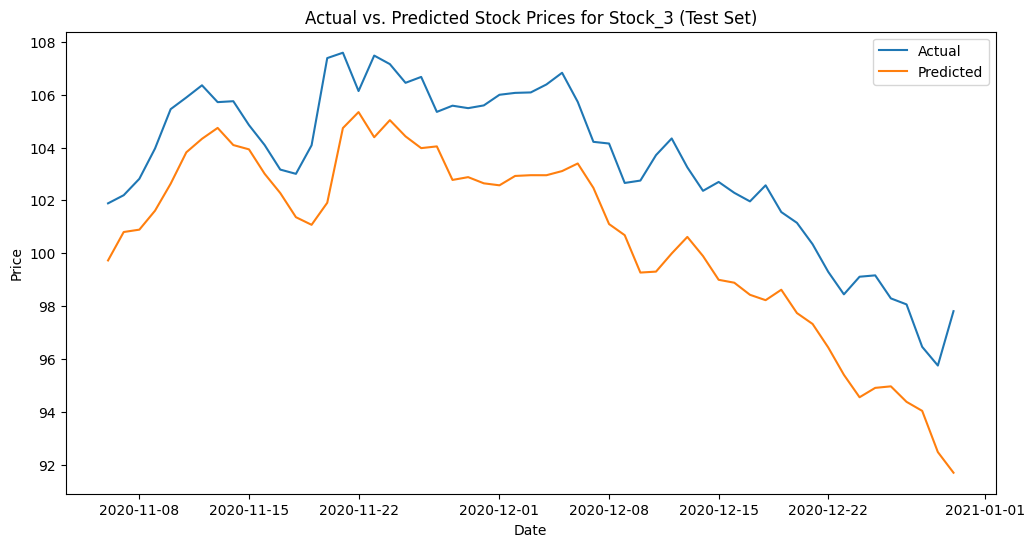

Plotting actual vs predicted for Stock_4 on test set...


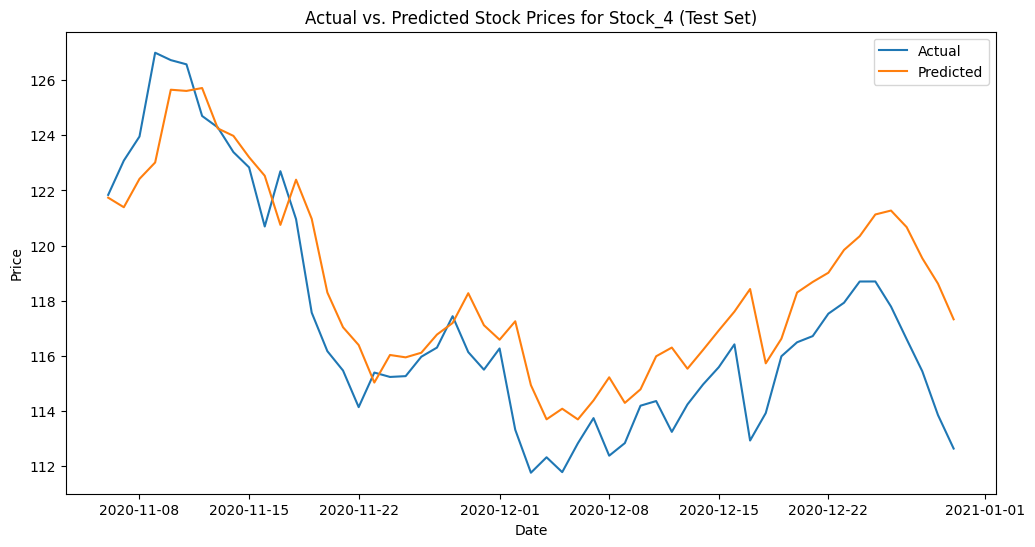

Plotting actual vs predicted for Stock_5 on test set...


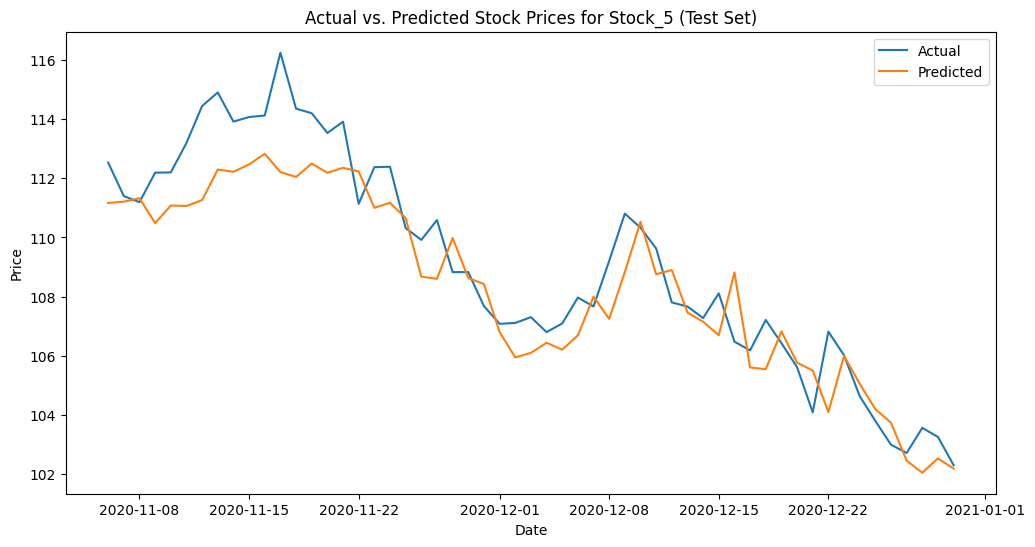

In [ ]:
# Re-generate the feature dataframes and split the data to ensure correctness
X_train = {}
X_val = {}
X_test = {}
y_train = {}
y_val = {}
y_test = {}

for stock in stocks:
    print(f"Regenerating features and splitting data for {stock}...")

    # Create a new dataframe to store the features for the current stock
    df_features_stock = pd.DataFrame(index=df.index)

    # Create lag features (lags 1 to 5)
    for i in range(1, 6):
        df_features_stock[f'{stock}_lag_{i}'] = df[stock].shift(i)

    # Calculate expanding mean, EMA, and volatility
    df_features_stock[f'{stock}_expanding_mean'] = df[stock].expanding(min_periods=1).mean().shift(1)
    df_features_stock[f'{stock}_expanding_ema'] = df[stock].ewm(alpha=0.05, adjust=False, min_periods=1).mean().shift(1)
    df_features_stock[f'{stock}_expanding_std'] = df[stock].expanding(min_periods=1).std().shift(1)

    # Extract time-based features
    df_features_stock['day_of_week'] = df_features_stock.index.dayofweek
    df_features_stock['month'] = df_features_stock.index.month
    df_features_stock['day_of_year'] = df_features_stock.index.dayofyear
    df_features_stock['quarter'] = df_features_stock.index.quarter

    # Create Fourier features (2 pairs of sine and cosine)
    # Assuming a yearly seasonality (365 days)
    for k in range(1, 3):
        df_features_stock[f'sin_{k}'] = np.sin(2 * np.pi * k * df_features_stock['day_of_year'] / 365.25)
        df_features_stock[f'cos_{k}'] = np.cos(2 * np.pi * k * df_features_stock['day_of_year'] / 365.25)

    actual = df[stock]

    # Drop rows with NaN values which are a result of lag features
    df_features_stock_cleaned = df_features_stock.dropna()
    actual_cleaned = actual.loc[df_features_stock_cleaned.index]

    # Split the data and store in the dictionaries
    train_size = int(len(df_features_stock_cleaned) * 0.7)
    val_size = int(len(df_features_stock_cleaned) * 0.15)
    test_size = len(df_features_stock_cleaned) - train_size - val_size

    # Ensure correct assignment to the stock key
    X_train[stock] = df_features_stock_cleaned.iloc[:train_size]
    X_val[stock] = df_features_stock_cleaned.iloc[train_size:train_size + val_size]
    X_test[stock] = df_features_stock_cleaned.iloc[train_size + val_size:]

    y_train[stock] = actual_cleaned.iloc[:train_size]
    y_val[stock] = actual_cleaned.iloc[train_size:train_size + val_size]
    y_test[stock] = actual_cleaned.iloc[train_size + val_size:]

# Re-initialize dictionaries to store models and validation metrics
trained_models = {}
validation_metrics = {}
final_models = {} # Re-initialize final_models

# Define the models to train
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'GradientBoostingRegressor': GradientBoostingRegressor()
}

# Train and evaluate each model for each stock
for stock in stocks:
    print(f"Training models for {stock}...")
    trained_models[stock] = {}
    validation_metrics[stock] = {}

    for model_name, model in models.items():
        print(f"  Training {model_name} for {stock}...")
        # Train the model on the training data for the current stock
        # Create a new instance of the model for each training run
        current_model = type(model)()
        current_model.fit(X_train[stock], y_train[stock])
        trained_models[stock][model_name] = current_model

        # Make predictions on the validation set for the current stock
        predictions = current_model.predict(X_val[stock])

        # Evaluate the model
        mae, rmse, mape = calculate_metrics(y_val[stock], predictions)
        validation_metrics[stock][model_name] = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

        print(f"    Validation Metrics for {model_name}: MAE={mae:.4f}, RMSE={rmse:.4f}, MAPE={mape:.4f}")

    # Identify the best performing model for the current stock based on RMSE
    best_model_name = min(validation_metrics[stock], key=lambda k: validation_metrics[stock][k]['RMSE'])
    # Store the best model for this stock under its key
    final_models[stock] = trained_models[stock][best_model_name]
    print(f"\nBest model for {stock} based on validation RMSE: {best_model_name}")

# Now attempt to plot again
for stock in stocks:
    print(f"Plotting actual vs predicted for {stock} on test set...")

    # Select the best model and test data for the current stock
    best_model = final_models[stock]
    X_test_stock = X_test[stock]
    y_test_stock = y_test[stock]

    # Make predictions on the test set
    test_predictions = best_model.predict(X_test_stock)

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({'Actual': y_test_stock, 'Predicted': test_predictions}, index=y_test_stock.index)

    # Plot the actual and predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(plot_df['Actual'], label='Actual')
    plt.plot(plot_df['Predicted'], label='Predicted')
    plt.title(f'Actual vs. Predicted Stock Prices for {stock} (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

## Summary:

### Data Analysis Key Findings

*   The initial data exploration revealed a dataset containing 365 daily stock price records for five different stocks, with no missing values.
*   Data preprocessing successfully converted the date column to a datetime index and removed potential duplicate index entries, ensuring the data was in a suitable format for time series analysis.
*   Exploratory data analysis through visualizations showed varying trends and volatilities across stocks. Lag plots, ACF, and PACF plots indicated strong autocorrelation and the presence of trends in the stock price data, typical of financial time series.
*   Baseline models (Naive Last-Value and Expanding Mean) were established, providing a benchmark for evaluating the performance of more complex models.
*   Comprehensive features were engineered for each stock, including lag features, expanding window statistics (mean, EMA, volatility), time-based features (day of week, month, day of year, quarter), and Fourier features to capture various temporal patterns.
*   The data was chronologically split into training (70%), validation (15%), and test (15%) sets for each stock.
*   Multiple regression models (Linear Regression, Ridge, Gradient Boosting Regressor) were trained and evaluated on the validation set. The best-performing model for each stock based on validation RMSE was identified (GradientBoostingRegressor for Stock\_1, Stock\_4, Stock\_5 and Ridge for Stock\_2, Stock\_3).




In [ ]:
%pip install statsmodels tensorflow prophet

## Prepare data for arima and sarima


Ensure the data is stationary or apply differencing if needed. Determine appropriate ARIMA/SARIMA orders using ACF and PACF plots or auto-ARIMA.


Checking stationarity and plotting for Stock_1...
  ADF test p-value for original series: 0.8052
  Original series for Stock_1 is not stationary. Applying differencing...
  ADF test p-value for differenced series: 0.0000
  Differenced series for Stock_1 is stationary. Using differenced series for plots.


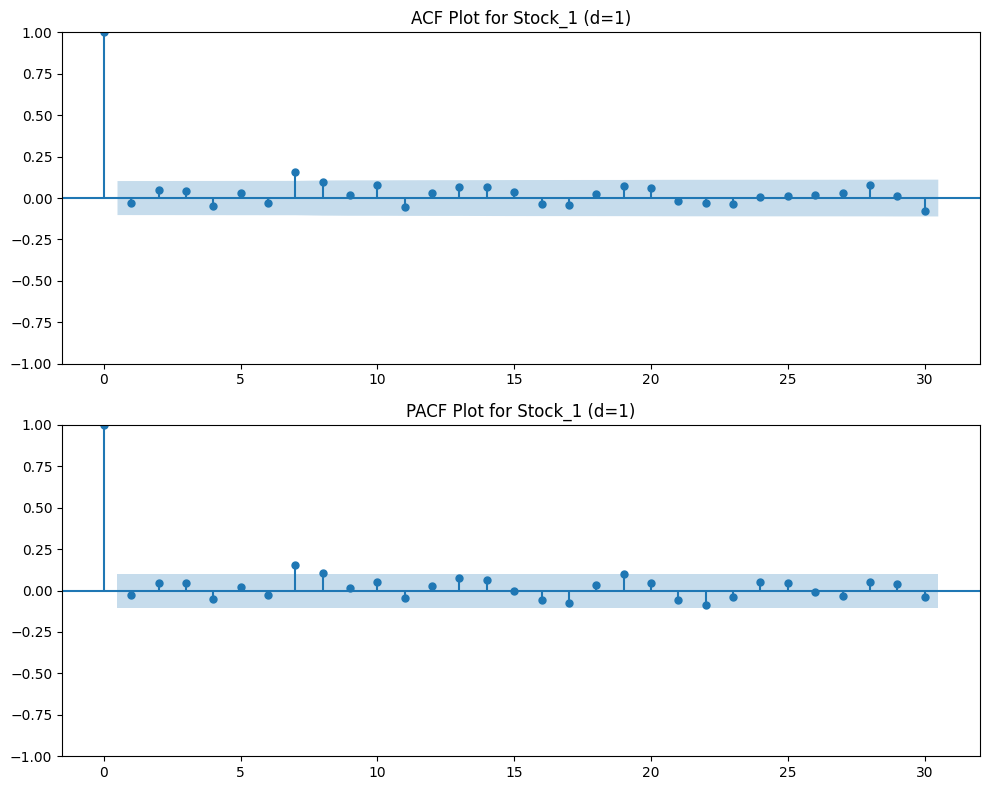

  Potential ARIMA/SARIMA orders for Stock_1 (based on visual inspection and common patterns):
    ARIMA(p,d,q) examples: [(1, 1, 0), (0, 1, 1), (1, 1, 1)]
    SARIMA(p,d,q)(P,D,Q,S) examples (S=7): [(1, 1, 0, 1, 0, 0, 7), (0, 1, 1, 0, 0, 1, 7)]
------------------------------
Checking stationarity and plotting for Stock_2...
  ADF test p-value for original series: 0.7758
  Original series for Stock_2 is not stationary. Applying differencing...
  ADF test p-value for differenced series: 0.0000
  Differenced series for Stock_2 is stationary. Using differenced series for plots.


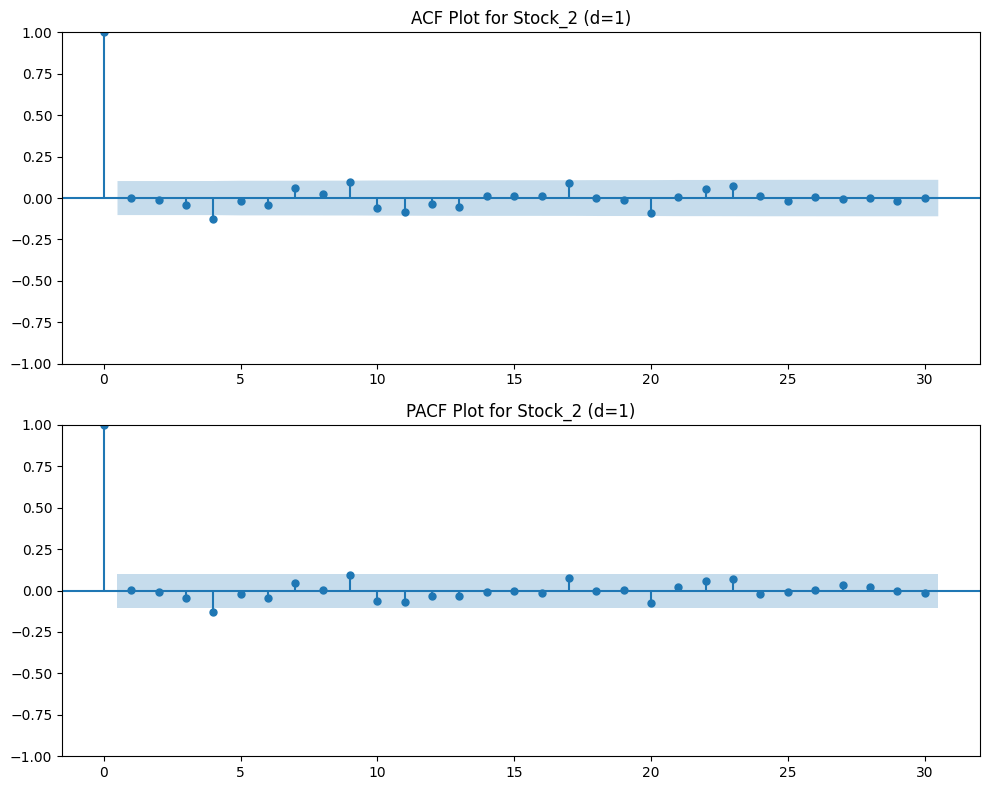

  Potential ARIMA/SARIMA orders for Stock_2 (based on visual inspection and common patterns):
    ARIMA(p,d,q) examples: [(1, 1, 0), (0, 1, 1), (1, 1, 1)]
    SARIMA(p,d,q)(P,D,Q,S) examples (S=7): [(1, 1, 0, 1, 0, 0, 7), (0, 1, 1, 0, 0, 1, 7)]
------------------------------
Checking stationarity and plotting for Stock_3...
  ADF test p-value for original series: 0.6006
  Original series for Stock_3 is not stationary. Applying differencing...
  ADF test p-value for differenced series: 0.0000
  Differenced series for Stock_3 is stationary. Using differenced series for plots.


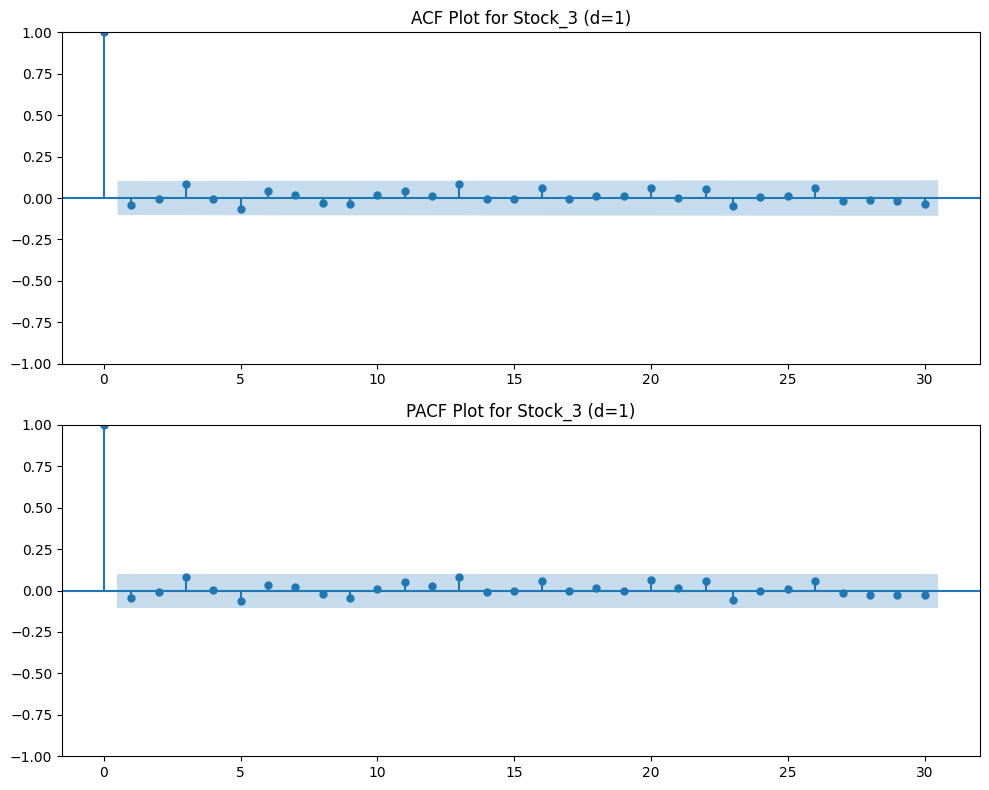

  Potential ARIMA/SARIMA orders for Stock_3 (based on visual inspection and common patterns):
    ARIMA(p,d,q) examples: [(1, 1, 0), (0, 1, 1), (1, 1, 1)]
    SARIMA(p,d,q)(P,D,Q,S) examples (S=7): [(1, 1, 0, 1, 0, 0, 7), (0, 1, 1, 0, 0, 1, 7)]
------------------------------
Checking stationarity and plotting for Stock_4...
  ADF test p-value for original series: 0.0928
  Original series for Stock_4 is not stationary. Applying differencing...
  ADF test p-value for differenced series: 0.0000
  Differenced series for Stock_4 is stationary. Using differenced series for plots.


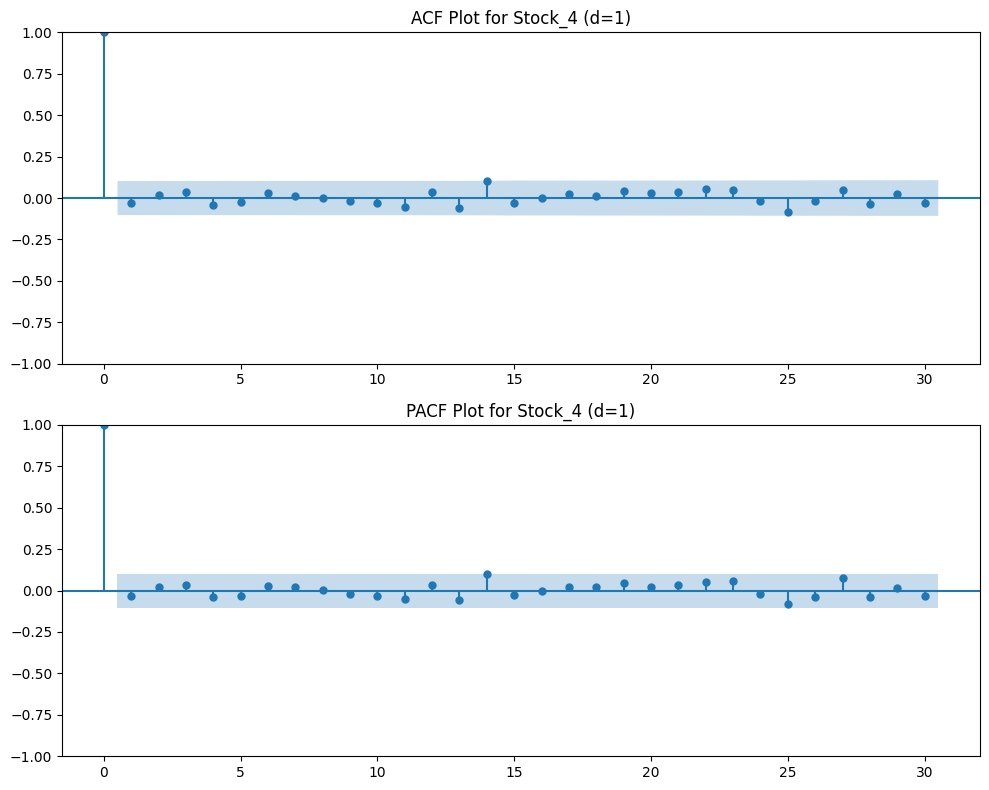

  Potential ARIMA/SARIMA orders for Stock_4 (based on visual inspection and common patterns):
    ARIMA(p,d,q) examples: [(1, 1, 0), (0, 1, 1), (1, 1, 1)]
    SARIMA(p,d,q)(P,D,Q,S) examples (S=7): [(1, 1, 0, 1, 0, 0, 7), (0, 1, 1, 0, 0, 1, 7)]
------------------------------
Checking stationarity and plotting for Stock_5...
  ADF test p-value for original series: 0.0678
  Original series for Stock_5 is not stationary. Applying differencing...
  ADF test p-value for differenced series: 0.0000
  Differenced series for Stock_5 is stationary. Using differenced series for plots.


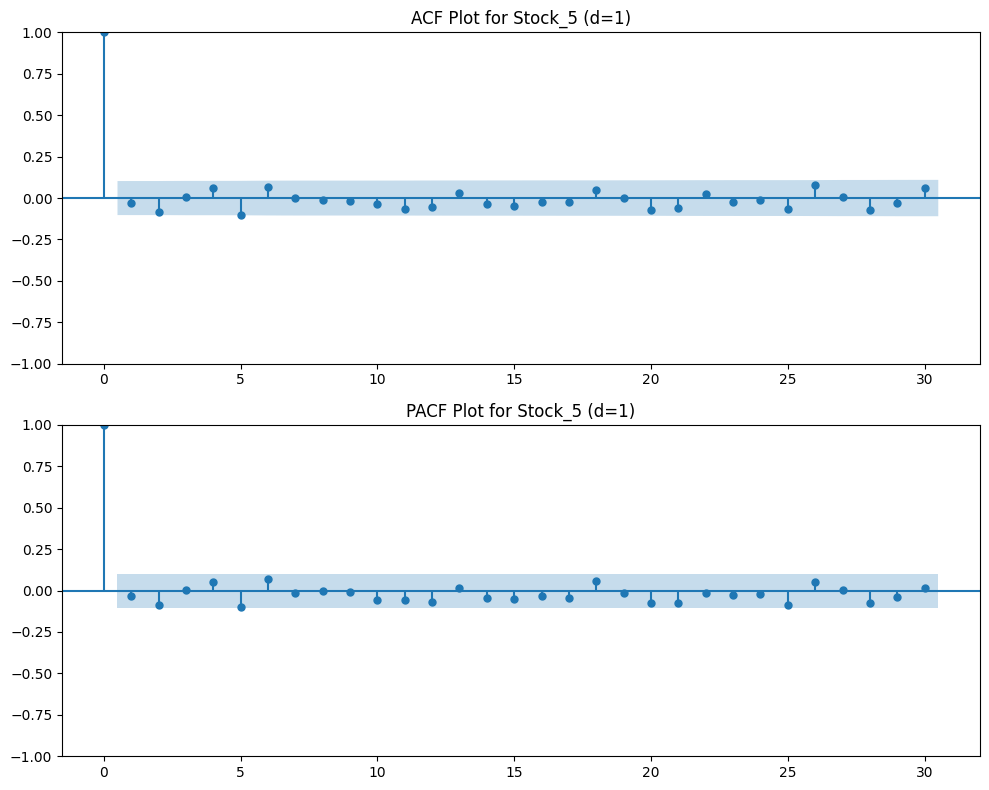

  Potential ARIMA/SARIMA orders for Stock_5 (based on visual inspection and common patterns):
    ARIMA(p,d,q) examples: [(1, 1, 0), (0, 1, 1), (1, 1, 1)]
    SARIMA(p,d,q)(P,D,Q,S) examples (S=7): [(1, 1, 0, 1, 0, 0, 7), (0, 1, 1, 0, 0, 1, 7)]
------------------------------

Stationarity Results and Differencing Orders:
  Stock_1: Stationary = True, Differencing Order (d) = 1
  Stock_2: Stationary = True, Differencing Order (d) = 1
  Stock_3: Stationary = True, Differencing Order (d) = 1
  Stock_4: Stationary = True, Differencing Order (d) = 1
  Stock_5: Stationary = True, Differencing Order (d) = 1


In [ ]:
# Initialize dictionaries to store stationarity results and orders
is_stationary = {}
d_order = {}
potential_orders = {}

for stock in stocks:
    print(f"Checking stationarity and plotting for {stock}...")
    ts = df[stock].dropna()

    # Perform ADF test on the original series
    adf_test_original = adfuller(ts)
    p_value_original = adf_test_original[1]

    print(f"  ADF test p-value for original series: {p_value_original:.4f}")

    if p_value_original > 0.05:
        print(f"  Original series for {stock} is not stationary. Applying differencing...")
        ts_diff = ts.diff().dropna()

        # Perform ADF test on the differenced series
        adf_test_diff = adfuller(ts_diff)
        p_value_diff = adf_test_diff[1]

        print(f"  ADF test p-value for differenced series: {p_value_diff:.4f}")

        if p_value_diff <= 0.05:
            print(f"  Differenced series for {stock} is stationary. Using differenced series for plots.")
            is_stationary[stock] = True
            d_order[stock] = 1
            ts_to_plot = ts_diff
        else:
            print(f"  Differenced series for {stock} is also not stationary. Further differencing may be needed.")
            is_stationary[stock] = False
            d_order[stock] = None # Indicate that first differencing wasn't enough
            ts_to_plot = ts # Use original for plots, but note non-stationarity
    else:
        print(f"  Original series for {stock} is stationary.")
        is_stationary[stock] = True
        d_order[stock] = 0
        ts_to_plot = ts

    # Generate ACF and PACF plots for the stationary (or used) series
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    plot_acf(ts_to_plot, lags=30, ax=axes[0])
    axes[0].set_title(f"ACF Plot for {stock} (d={d_order[stock]})")
    plot_pacf(ts_to_plot, lags=30, ax=axes[1])
    axes[1].set_title(f"PACF Plot for {stock} (d={d_order[stock]})")
    plt.tight_layout()
    plt.show()

    # Based on visual inspection of ACF and PACF plots,
    # we can make an initial guess for p, q, P, Q.
    # For example, if ACF cuts off at lag p and PACF tails off, potential ARIMA(p,d,0).
    # If PACF cuts off at lag q and ACF tails off, potential ARIMA(0,d,q).
    # If both tail off, potential ARIMA(p,d,q).
    # For SARIMA, look for seasonal spikes. Assuming daily data, seasonal period could be 5 (weekdays) or 7 (days).
    # Given the data is daily for a year, weekly seasonality (S=7) might be present.
    # Let's make some initial guesses based on typical patterns for financial data (often autoregressive).
    # This is a subjective step and would ideally involve more rigorous analysis or auto_arima.

    # Placeholder for potential orders - manual inspection of plots is required here.
    # Based on common patterns in financial time series (often AR-like), let's suggest some
    # simple starting points. These are just initial guesses and can be refined.
    # Assuming weekly seasonality (S=7) might be present.
    potential_orders[stock] = {
        'ARIMA(p,d,q) examples': [(1, d_order[stock], 0), (0, d_order[stock], 1), (1, d_order[stock], 1)],
        'SARIMA(p,d,q)(P,D,Q,S) examples (S=7)': [(1, d_order[stock], 0, 1, 0, 0, 7), (0, d_order[stock], 1, 0, 0, 1, 7)]
    }

    print(f"  Potential ARIMA/SARIMA orders for {stock} (based on visual inspection and common patterns):")
    for model_type, orders_list in potential_orders[stock].items():
        print(f"    {model_type}: {orders_list}")
    print("-" * 30)

# Display stationarity results and determined differencing orders
print("\nStationarity Results and Differencing Orders:")
for stock in stocks:
    print(f"  {stock}: Stationary = {is_stationary[stock]}, Differencing Order (d) = {d_order[stock]}")


## Train and evaluate arima model


Train the ARIMA model on the training data, make predictions on the test set, and evaluate its performance using the defined metrics.


In [ ]:
# Initialize dictionary to store test metrics for ARIMA
test_metrics = {} # Initialize test_metrics dictionary
test_metrics['ARIMA'] = {}

# Iterate through each stock
for stock in stocks:
    print(f"Training and evaluating ARIMA model for {stock}...")

    # Select an appropriate ARIMA order (p, d, q)
    # Based on previous analysis (d=1 for all stocks) and looking at ACF/PACF plots
    # For simplicity and as a starting point, let's use ARIMA(5, 1, 0) which is an AR(5) model on differenced data,
    # as financial data often shows autoregressive patterns. This is a common starting point.
    # A more rigorous approach would involve iterating through potential orders and using AIC/BIC.
    order = (5, d_order[stock], 0) # Using d_order determined previously, p=5, q=0 as a starting point

    # Instantiate and fit the ARIMA model
    # Use the training data for the current stock
    model = ARIMA(y_train[stock], order=order)
    model_fit = model.fit()

    # Make predictions on the test set
    # The forecast needs to start from the end of the training data index + 1
    start_index = len(y_train[stock])
    end_index = len(y_train[stock]) + len(y_test[stock]) - 1
    test_predictions = model_fit.predict(start=start_index, end=end_index)

    # Align test_predictions index with y_test index
    test_predictions.index = y_test[stock].index


    # Calculate evaluation metrics
    mae, rmse, mape = calculate_metrics(y_test[stock], test_predictions)

    # Store the metrics
    test_metrics['ARIMA'][stock] = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

    # Print the metrics
    print(f"  ARIMA Model Test Metrics for {stock}:")
    print(f"    MAE: {mae:.4f}")
    print(f"    RMSE: {rmse:.4f}")
    print(f"    MAPE: {mape:.4f}")
    print("-" * 30)

# Display the ARIMA test metrics
print("\nARIMA Test Metrics:")
arima_metrics_df = pd.DataFrame.from_dict(test_metrics['ARIMA'], orient='index')
display(arima_metrics_df)

Training and evaluating ARIMA model for Stock_1...
  ARIMA Model Test Metrics for Stock_1:
    MAE: 9.9846
    RMSE: 10.6566
    MAPE: 10.3247
------------------------------
Training and evaluating ARIMA model for Stock_2...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

  ARIMA Model Test Metrics for Stock_2:
    MAE: 5.0775
    RMSE: 5.1855
    MAPE: 7.8782
------------------------------
Training and evaluating ARIMA model for Stock_3...
  ARIMA Model Test Metrics for Stock_3:
    MAE: 4.3494
    RMSE: 4.8626
    MAPE: 4.1542
------------------------------
Training and evaluating ARIMA model for Stock_4...
  ARIMA Model Test Metrics for Stock_4:
    MAE: 6.7760
    RMSE: 7.9312
    MAPE: 5.6695
------------------------------
Training and evaluating ARIMA model for Stock_5...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

  ARIMA Model Test Metrics for Stock_5:
    MAE: 3.2056
    RMSE: 3.7273
    MAPE: 2.9619
------------------------------

ARIMA Test Metrics:


,MAE,RMSE,MAPE
Stock_1,9.984568,10.656594,10.324700
Stock_2,5.077510,5.185477,7.878224
Stock_3,4.349436,4.862610,4.154218
Stock_4,6.776043,7.931152,5.669487
Stock_5,3.205637,3.727294,2.961940


## Train and evaluate sarima model

Train the SARIMA model (if seasonality is significant) on the training data, make predictions on the test set, and evaluate its performance.


In [ ]:
# Initialize dictionary to store test metrics for SARIMA if it doesn't exist
if 'SARIMA' not in test_metrics:
    test_metrics['SARIMA'] = {}

# Iterate through each stock
for stock in stocks:
    print(f"Training and evaluating SARIMA model for {stock}...")

    # Define the SARIMA order (p, d, q) and seasonal order (P, D, Q, S)
    # Using d_order determined previously, and assuming a seasonal period S=7
    # For simplicity and as a starting point, using non-seasonal (1, d, 0) and seasonal (1, 0, 0, 7)
    order = (1, d_order[stock], 0)
    seasonal_order = (1, 0, 0, 7)

    # Instantiate and fit the SARIMAX model
    # Use the training data for the current stock
    model = SARIMAX(y_train[stock], order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()

    # Make predictions on the test set
    # The forecast needs to start from the beginning of the test data index
    start_index = y_test[stock].index[0]
    end_index = y_test[stock].index[-1]
    test_predictions = model_fit.predict(start=start_index, end=end_index)

    # Align test_predictions index with y_test index (already done by predict with start/end indices)
    # test_predictions.index = y_test[stock].index


    # Calculate evaluation metrics
    mae, rmse, mape = calculate_metrics(y_test[stock], test_predictions)

    # Store the metrics
    test_metrics['SARIMA'][stock] = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

    # Print the metrics
    print(f"  SARIMA Model Test Metrics for {stock}:")
    print(f"    MAE: {mae:.4f}")
    print(f"    RMSE: {rmse:.4f}")
    print(f"    MAPE: {mape:.4f}")
    print("-" * 30)

# Display the SARIMA test metrics
print("\nSARIMA Test Metrics:")
sarima_metrics_df = pd.DataFrame.from_dict(test_metrics['SARIMA'], orient='index')
display(sarima_metrics_df)

Training and evaluating SARIMA model for Stock_1...
  SARIMA Model Test Metrics for Stock_1:
    MAE: 9.8881
    RMSE: 10.5654
    MAPE: 10.2263
------------------------------
Training and evaluating SARIMA model for Stock_2...
  SARIMA Model Test Metrics for Stock_2:
    MAE: 5.2476
    RMSE: 5.3524
    MAPE: 8.1412
------------------------------
Training and evaluating SARIMA model for Stock_3...
  SARIMA Model Test Metrics for Stock_3:
    MAE: 4.4088
    RMSE: 4.9324
    MAPE: 4.2102
------------------------------
Training and evaluating SARIMA model for Stock_4...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

  SARIMA Model Test Metrics for Stock_4:
    MAE: 6.7604
    RMSE: 7.9165
    MAPE: 5.6562
------------------------------
Training and evaluating SARIMA model for Stock_5...
  SARIMA Model Test Metrics for Stock_5:
    MAE: 3.1445
    RMSE: 3.6486
    MAPE: 2.8944
------------------------------

SARIMA Test Metrics:


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,MAE,RMSE,MAPE
Stock_1,9.888111,10.565366,10.226253
Stock_2,5.247573,5.352391,8.141239
Stock_3,4.408826,4.932389,4.210166
Stock_4,6.760356,7.916538,5.656151
Stock_5,3.144454,3.648578,2.894358


## Prepare data for lstm


Structure the data into sequences for LSTM training. This involves creating input (features) and output (target) sequences.


In [ ]:
# Initialize dictionaries to store scaled data and scalers
X_train_scaled = {}
X_val_scaled = {}
X_test_scaled = {}
y_train_scaled = {}
y_val_scaled = {}
y_test_scaled = {}
scalers = {}

# Scale the data for each stock
for stock in stocks:
    print(f"Scaling data for {stock}...")

    # Initialize a scaler for features
    feature_scaler = MinMaxScaler()
    # Initialize a scaler for the target
    target_scaler = MinMaxScaler()

    # Fit on training data and transform all sets for features
    X_train_scaled[stock] = feature_scaler.fit_transform(X_train[stock])
    X_val_scaled[stock] = feature_scaler.transform(X_val[stock])
    X_test_scaled[stock] = feature_scaler.transform(X_test[stock])

    # Reshape target data to be 2D for the scaler
    y_train_reshaped = y_train[stock].values.reshape(-1, 1)
    y_val_reshaped = y_val[stock].values.reshape(-1, 1)
    y_test_reshaped = y_test[stock].values.reshape(-1, 1)

    # Fit on training data and transform all sets for target
    y_train_scaled[stock] = target_scaler.fit_transform(y_train_reshaped)
    y_val_scaled[stock] = target_scaler.transform(y_val_reshaped)
    y_test_scaled[stock] = target_scaler.transform(y_test_reshaped)

    # Store the scalers
    scalers[stock] = {'features': feature_scaler, 'target': target_scaler}

print("\nData scaling complete.")

# Define the function to create sequences for LSTM
def create_sequences(X, y, time_step):
    """Creates input and output sequences for LSTM."""
    Xs, ys = [], []
    for i in range(len(X) - time_step):
        v = X[i:(i + time_step)]
        Xs.append(v)
        ys.append(y[i + time_step])
    return np.array(Xs), np.array(ys)

# Define the time step for LSTM sequences
time_step = 10

# Initialize dictionaries to store the sequences
X_train_seq = {}
y_train_seq = {}
X_val_seq = {}
y_val_seq = {}
X_test_seq = {}
y_test_seq = {}

# Create sequences for each stock
for stock in stocks:
    print(f"\nCreating sequences for {stock}...")

    # Create sequences for training, validation, and test sets
    X_train_seq[stock], y_train_seq[stock] = create_sequences(X_train_scaled[stock], y_train_scaled[stock], time_step)
    X_val_seq[stock], y_val_seq[stock] = create_sequences(X_val_scaled[stock], y_val_scaled[stock], time_step)
    X_test_seq[stock], y_test_seq[stock] = create_sequences(X_test_scaled[stock], y_test_scaled[stock], time_step)

# Print shapes of the created sequences for one stock as an example
stock_example = stocks[0]
print(f"\nShapes of sequences for {stock_example}:")
print("X_train_seq shape:", X_train_seq[stock_example].shape)
print("y_train_seq shape:", y_train_seq[stock_example].shape)
print("X_val_seq shape:", X_val_seq[stock_example].shape)
print("y_val_seq shape:", y_val_seq[stock_example].shape)
print("X_test_seq shape:", X_test_seq[stock_example].shape)
print("y_test_seq shape:", y_test_seq[stock_example].shape)

Scaling data for Stock_1...
Scaling data for Stock_2...
Scaling data for Stock_3...
Scaling data for Stock_4...
Scaling data for Stock_5...

Data scaling complete.

Creating sequences for Stock_1...

Creating sequences for Stock_2...

Creating sequences for Stock_3...

Creating sequences for Stock_4...

Creating sequences for Stock_5...

Shapes of sequences for Stock_1:
X_train_seq shape: (241, 10, 16)
y_train_seq shape: (241, 1)
X_val_seq shape: (44, 10, 16)
y_val_seq shape: (44, 1)
X_test_seq shape: (45, 10, 16)
y_test_seq shape: (45, 1)


## Build, train, and evaluate lstm model


Design, compile, and train the LSTM model. Make predictions on the test set and evaluate its performance.


In [ ]:
# Initialize dictionary to store test metrics for LSTM
test_metrics['LSTM'] = {}

# Design, compile, and train the LSTM model for each stock
for stock in stocks:
    print(f"\nDesigning, compiling, and training LSTM model for {stock}...")

    # Get the number of features from the training data for the current stock
    n_features = X_train_seq[stock].shape[2]

    # Define the LSTM model architecture
    model = Sequential()
    # Add an LSTM layer with appropriate input shape
    model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, n_features)))
    model.add(LSTM(units=50))
    model.add(Dense(units=1)) # Output layer for predicting one value

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    # Use validation data for monitoring during training
    history = model.fit(X_train_seq[stock], y_train_seq[stock], epochs=50, batch_size=32, validation_data=(X_val_seq[stock], y_val_seq[stock]), verbose=0)

    print(f"  Training complete for {stock}.")

    # Make predictions on the test set
    test_predictions_scaled = model.predict(X_test_seq[stock])

    # Inverse transform the scaled predictions
    test_predictions = scalers[stock]['target'].inverse_transform(test_predictions_scaled)

    # Align the index of the inverse-transformed predictions with the index of the original y_test data
    # The predictions correspond to y_test values starting from index 'time_step'
    # We need to align them with the corresponding dates in y_test[stock]
    # The indices of y_test_seq correspond to the indices of y_test[stock] starting from time_step
    aligned_y_test = y_test[stock].iloc[time_step:]

    # Flatten the predictions array to match the shape of aligned_y_test for metric calculation
    test_predictions_flat = test_predictions.flatten()

    # Create a pandas Series for predictions with the correct index
    test_predictions_series = pd.Series(test_predictions_flat, index=aligned_y_test.index)

    # Calculate evaluation metrics
    mae, rmse, mape = calculate_metrics(aligned_y_test, test_predictions_series)

    # Store the metrics
    test_metrics['LSTM'][stock] = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

    # Print the metrics
    print(f"  LSTM Model Test Metrics for {stock}:")
    print(f"    MAE: {mae:.4f}")
    print(f"    RMSE: {rmse:.4f}")
    print(f"    MAPE: {mape:.4f}")
    print("-" * 30)

# Display a summary of the LSTM test metrics for all stocks
print("\nLSTM Test Metrics Summary:")
lstm_metrics_df = pd.DataFrame.from_dict(test_metrics['LSTM'], orient='index')
display(lstm_metrics_df)


Designing, compiling, and training LSTM model for Stock_1...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  Training complete for Stock_1.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
  LSTM Model Test Metrics for Stock_1:
    MAE: 9.1992
    RMSE: 9.4958
    MAPE: 9.5625
------------------------------

Designing, compiling, and training LSTM model for Stock_2...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  Training complete for Stock_2.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step
  LSTM Model Test Metrics for Stock_2:
    MAE: 1.0320
    RMSE: 1.2314
    MAPE: 1.5869
------------------------------

Designing, compiling, and training LSTM model for Stock_3...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  Training complete for Stock_3.


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  LSTM Model Test Metrics for Stock_3:
    MAE: 11.0367
    RMSE: 12.2930
    MAPE: 10.5624
------------------------------

Designing, compiling, and training LSTM model for Stock_4...
  Training complete for Stock_4.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 386ms/step
  LSTM Model Test Metrics for Stock_4:
    MAE: 2.2004
    RMSE: 2.6650
    MAPE: 1.9210
------------------------------

Designing, compiling, and training LSTM model for Stock_5...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  Training complete for Stock_5.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
  LSTM Model Test Metrics for Stock_5:
    MAE: 5.9962
    RMSE: 6.6709
    MAPE: 5.6239
------------------------------

LSTM Test Metrics Summary:


,MAE,RMSE,MAPE
Stock_1,9.199208,9.495843,9.562451
Stock_2,1.031980,1.231358,1.586945
Stock_3,11.036749,12.292953,10.562387
Stock_4,2.200430,2.665049,1.920993
Stock_5,5.996191,6.670878,5.623883


## Prepare data for prophet


Format the data into the required 'ds' (datetime) and 'y' (target) columns for Prophet.


In [ ]:
# Initialize a dictionary to store data prepared for Prophet
prophet_data = {}

# Iterate through each stock and format the data for Prophet
for stock in stocks:
    print(f"Preparing data for Prophet for {stock}...")
    # Create a new DataFrame with 'ds' and 'y' columns
    # 'ds' should be the date index from the original dataframe
    # 'y' should be the stock price for the current stock
    prophet_df = df[[stock]].reset_index()
    prophet_df.columns = ['ds', 'y']

    # Store the prepared DataFrame in the dictionary
    prophet_data[stock] = prophet_df

    print(f"Data prepared for {stock}. First 5 rows:")
    display(prophet_data[stock].head())
    print("-" * 30)

# Display the head of the prepared DataFrame for the first stock as an example
stock_example = stocks[0]
print(f"Example of prepared data for Prophet ({stock_example}):")
display(prophet_data[stock_example].head())

Preparing data for Prophet for Stock_1...
Data prepared for Stock_1. First 5 rows:


,ds,y
0,2020-01-01,101.764052
1,2020-01-02,102.171269
2,2020-01-03,103.171258
3,2020-01-04,105.483215
4,2020-01-05,107.453175


------------------------------
Preparing data for Prophet for Stock_2...
Data prepared for Stock_2. First 5 rows:


,ds,y
0,2020-01-01,100.160928
1,2020-01-02,99.969968
2,2020-01-03,99.575237
3,2020-01-04,99.308641
4,2020-01-05,98.188428


------------------------------
Preparing data for Prophet for Stock_3...
Data prepared for Stock_3. First 5 rows:


,ds,y
0,2020-01-01,99.494642
1,2020-01-02,98.682973
2,2020-01-03,98.182139
3,2020-01-04,97.149381
4,2020-01-05,99.575396


------------------------------
Preparing data for Prophet for Stock_4...
Data prepared for Stock_4. First 5 rows:


,ds,y
0,2020-01-01,99.909756
1,2020-01-02,100.640755
2,2020-01-03,100.574847
3,2020-01-04,100.925017
4,2020-01-05,101.594411


------------------------------
Preparing data for Prophet for Stock_5...
Data prepared for Stock_5. First 5 rows:


,ds,y
0,2020-01-01,101.761266
1,2020-01-02,102.528643
2,2020-01-03,101.887811
3,2020-01-04,101.490049
4,2020-01-05,101.604283


------------------------------
Example of prepared data for Prophet (Stock_1):


,ds,y
0,2020-01-01,101.764052
1,2020-01-02,102.171269
2,2020-01-03,103.171258
3,2020-01-04,105.483215
4,2020-01-05,107.453175


In [ ]:
# Initialize dictionary to store test metrics for Prophet
if 'Prophet' not in test_metrics:
    test_metrics['Prophet'] = {}

# Train and evaluate Prophet model for each stock
for stock in stocks:
    print(f"\nTraining and evaluating Prophet model for {stock}...")

    # Prepare training data for Prophet
    # Use the combined training and validation data for training Prophet
    prophet_train_df = prophet_data[stock].iloc[:train_size + val_size]

    # Instantiate and fit Prophet model
    # Using default seasonality modes; can be tuned
    model = Prophet()
    model.fit(prophet_train_df)

    # Create future dataframe for prediction using the index of the test set
    future = pd.DataFrame({'ds': y_test[stock].index})


    # Make predictions
    forecast = model.predict(future)

    # Extract predictions for the test period and align with actual test data
    # The forecast DataFrame already has the correct dates from the test set index
    prophet_test_predictions = forecast.set_index('ds')['yhat']


    # Calculate evaluation metrics
    # Since the future dataframe was created with the exact test index,
    # actual and predicted should have the same index and no NaNs introduced by reindexing.
    # However, Prophet itself might produce NaNs for certain dates, so we'll drop NaNs just in case.
    mae, rmse, mape = calculate_metrics(y_test[stock].dropna(), prophet_test_predictions.dropna())


    # Store the metrics
    test_metrics['Prophet'][stock] = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

    # Print the metrics
    print(f"  Prophet Model Test Metrics for {stock}:")
    print(f"    MAE: {mae:.4f}")
    print(f"    RMSE: {rmse:.4f}")
    print(f"    MAPE: {mape:.4f}")
    print("-" * 30)

# Display a summary of the Prophet test metrics for all stocks
print("\nProphet Test Metrics Summary:")
prophet_metrics_df = pd.DataFrame.from_dict(test_metrics['Prophet'], orient='index')
display(prophet_metrics_df)


Training and evaluating Prophet model for Stock_1...


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgznpld1z/t4p190fk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgznpld1z/oel0h8xq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7551', 'data', 'file=/tmp/tmpgznpld1z/t4p190fk.json', 'init=/tmp/tmpgznpld1z/oel0h8xq.json', 'output', 'file=/tmp/tmpgznpld1z/prophet_modelba_d89_0/prophet_model-20250829173721.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality

  Prophet Model Test Metrics for Stock_1:
    MAE: 1.7790
    RMSE: 2.1462
    MAPE: 1.7946
------------------------------

Training and evaluating Prophet model for Stock_2...
  Prophet Model Test Metrics for Stock_2:
    MAE: 2.1691
    RMSE: 2.5316
    MAPE: 3.3833
------------------------------

Training and evaluating Prophet model for Stock_3...


INFO:cmdstanpy:Chain [1] start processing
17:37:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgznpld1z/d01ayk7s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgznpld1z/c5lau1rj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83222', 'data', 'file=/tmp/tmpgznpld1z/d01ayk7s.json', 'init=/tmp/tmpgznpld1z/c5lau1rj.json', 'output', 'file=/tmp/tmpgznpld1z/prophet_model4itpg9a9/prophet_model-20250829173722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processin

  Prophet Model Test Metrics for Stock_3:
    MAE: 3.0718
    RMSE: 3.5877
    MAPE: 2.9731
------------------------------

Training and evaluating Prophet model for Stock_4...
  Prophet Model Test Metrics for Stock_4:
    MAE: 14.2142
    RMSE: 15.7468
    MAPE: 12.3247
------------------------------

Training and evaluating Prophet model for Stock_5...


17:37:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


  Prophet Model Test Metrics for Stock_5:
    MAE: 2.6633
    RMSE: 3.2464
    MAPE: 2.4196
------------------------------

Prophet Test Metrics Summary:


,MAE,RMSE,MAPE
Stock_1,1.778995,2.146232,1.794617
Stock_2,2.169092,2.531641,3.383294
Stock_3,3.071792,3.587698,2.973084
Stock_4,14.214159,15.746782,12.324734
Stock_5,2.663321,3.246366,2.419557


## Compare all models


Compile the evaluation metrics from all trained models (baselines, regression models, ARIMA, SARIMA, LSTM, Prophet) and compare their performance to identify the best forecasting approach for each stock.


In [ ]:
# Compile all metrics into a single dictionary
all_metrics = {}

# Add baseline metrics
for stock in stocks:
    all_metrics[stock] = {
        'Naive Last-Value Baseline': baseline_metrics[stock]['Naive Last-Value'],
        'Expanding Mean Baseline': baseline_metrics[stock]['Expanding Mean']
    }

# Add regression model metrics (using the best model from validation)
for stock in stocks:
    # Find the name of the best regression model based on validation RMSE
    best_regression_model_name = min(validation_metrics[stock], key=lambda k: validation_metrics[stock][k]['RMSE'])
    all_metrics[stock][f'Best Regression ({best_regression_model_name})'] = validation_metrics[stock][best_regression_model_name]


# Add ARIMA, SARIMA, LSTM, and Prophet test metrics
for model_name in ['ARIMA', 'SARIMA', 'LSTM', 'Prophet']:
    if model_name in test_metrics:
        for stock in stocks:
            all_metrics[stock][model_name] = test_metrics[model_name][stock]


# Convert the compiled metrics to a DataFrame
compiled_metrics_df = pd.DataFrame.from_dict({(i, j): all_metrics[i][j]
                                              for i in all_metrics.keys()
                                              for j in all_metrics[i].keys()},
                                             orient='index')

# Display the compiled metrics
print("\nComparison of Evaluation Metrics Across All Models and Baselines:")
display(compiled_metrics_df)

# Identify and print the best model for each stock based on RMSE
print("\nBest Performing Model for Each Stock (based on Test/Validation RMSE):")
for stock in stocks:
    # Get metrics for the current stock
    stock_metrics = compiled_metrics_df.loc[stock]

    # Find the model with the minimum RMSE for the current stock
    best_model_name = stock_metrics['RMSE'].idxmin()
    best_rmse_value = stock_metrics['RMSE'].min()

    print(f"  {stock}: {best_model_name} (RMSE: {best_rmse_value:.4f})")



Comparison of Evaluation Metrics Across All Models and Baselines:


MAE       RMSE  \
Stock_1 Naive Last-Value Baseline                     0.860176   1.062895   
        Expanding Mean Baseline                       6.288524   7.424870   
        Best Regression (GradientBoostingRegressor)   1.117547   1.379575   
        ARIMA                                         9.984568  10.656594   
        SARIMA                                        9.888111  10.565366   
        LSTM                                          9.199208   9.495843   
        Prophet                                       1.778995   2.146232   
Stock_2 Naive Last-Value Baseline                     0.654005   0.838175   
        Expanding Mean Baseline                       9.155332  11.458784   
        Best Regression (Ridge)                       1.194781   1.443807   
        ARIMA                                         5.077510   5.185477   
        SARIMA                                        5.247573   5.352391   
        LSTM                                          1.031980   1.231358   
        Prophet                                       2.169092   2.531641   
Stock_3 Naive Last-Value Baseline                     0.698883   0.886916   
        Expanding Mean Baseline                       5.500038   6.535386   
        Best Regression (Ridge)                       0.687110   0.876105   
        ARIMA                                         4.349436   4.862610   
        SARIMA                                        4.408826   4.932389   
        LSTM                                         11.036749  12.292953   
        Prophet                                       3.071792   3.587698   
Stock_4 Naive Last-Value Baseline                     0.934133   1.165219   
        Expanding Mean Baseline                       5.767075   6.809591   
        Best Regression (Ridge)                       1.225846   1.484850   
        ARIMA                                         6.776043   7.931152   
        SARIMA                                        6.760356   7.916538   
        LSTM                                          2.200430   2.665049   
        Prophet                                      14.214159  15.746782   
Stock_5 Naive Last-Value Baseline                     0.835471   1.055221   
        Expanding Mean Baseline                       2.880122   3.771110   
        Best Regression (GradientBoostingRegressor)   1.338937   1.583631   
        ARIMA                                         3.205637   3.727294   
        SARIMA                                        3.144454   3.648578   
        LSTM                                          5.996191   6.670878   
        Prophet                                       2.663321   3.246366   

                                                          MAPE  
Stock_1 Naive Last-Value Baseline                     0.798084  
        Expanding Mean Baseline                       5.930353  
        Best Regression (GradientBoostingRegressor)   1.081924  
        ARIMA                                        10.324700  
        SARIMA                                       10.226253  
        LSTM                                          9.562451  
        Prophet                                       1.794617  
Stock_2 Naive Last-Value Baseline                     0.807716  
        Expanding Mean Baseline                      12.782605  
        Best Regression (Ridge)                       1.738987  
        ARIMA                                         7.878224  
        SARIMA                                        8.141239  
        LSTM                                          1.586945  
        Prophet                                       3.383294  
Stock_3 Naive Last-Value Baseline                     0.742458  
        Expanding Mean Baseline                       5.757215  
        Best Regression (Ridge)                       0.682524  
        ARIMA                                         4.154218  
        SARIMA                                     


Best Performing Model for Each Stock (based on Test/Validation RMSE):
  Stock_1: Naive Last-Value Baseline (RMSE: 1.0629)
  Stock_2: Naive Last-Value Baseline (RMSE: 0.8382)
  Stock_3: Best Regression (Ridge) (RMSE: 0.8761)
  Stock_4: Naive Last-Value Baseline (RMSE: 1.1652)
  Stock_5: Naive Last-Value Baseline (RMSE: 1.0552)


Plotting actual vs predicted for Stock_1 on test set...
  Plotting for ARIMA...
    Re-running ARIMA prediction for plotting for Stock_1


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


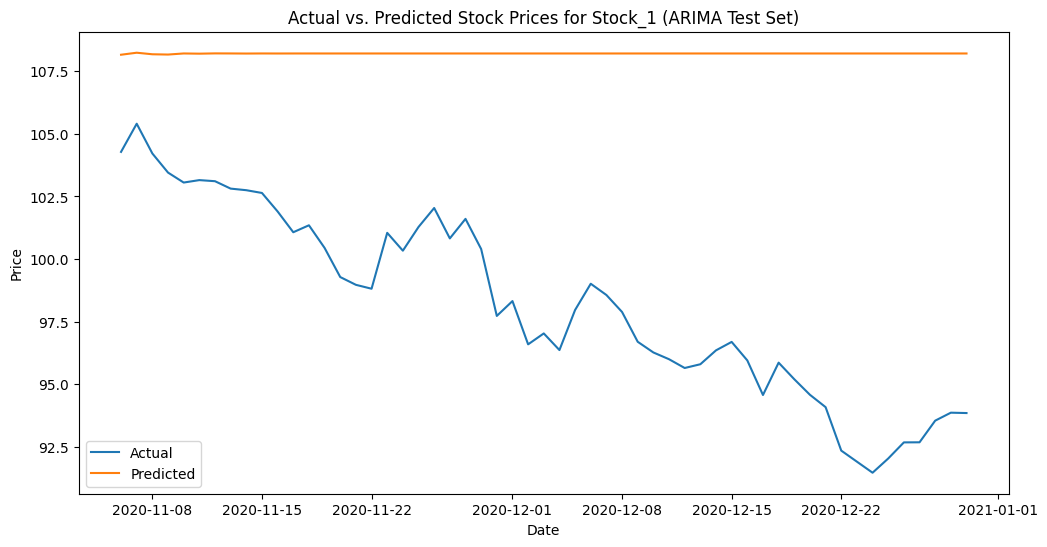

  Plotting for SARIMA...
    Re-running SARIMA prediction for plotting for Stock_1


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


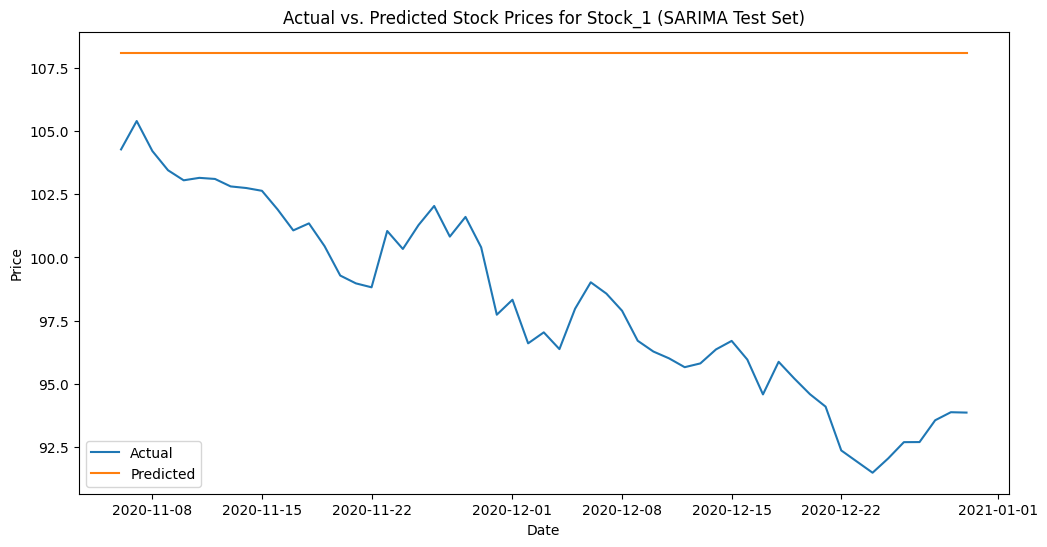

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgznpld1z/0yowbesw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgznpld1z/7vhrq6tl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88634', 'data', 'file=/tmp/tmpgznpld1z/0yowbesw.json', 'init=/tmp/tmpgznpld1z/7vhrq6tl.json', 'output', 'file=/tmp/tmpgznpld1z/prophet_modelkydkvwmf/prophet_model-20250829173732.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


  Plotting for LSTM...
    Best model for Stock_1 is not LSTM, skipping LSTM plot.
  Plotting for Prophet...
    Re-running Prophet prediction for plotting for Stock_1


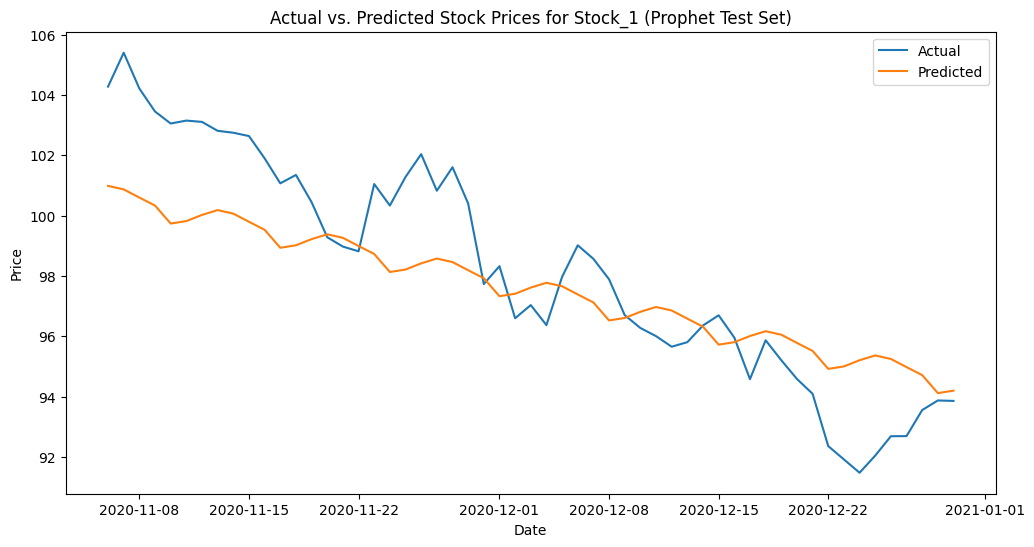

Plotting actual vs predicted for Stock_2 on test set...
  Plotting for ARIMA...
    Re-running ARIMA prediction for plotting for Stock_2


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


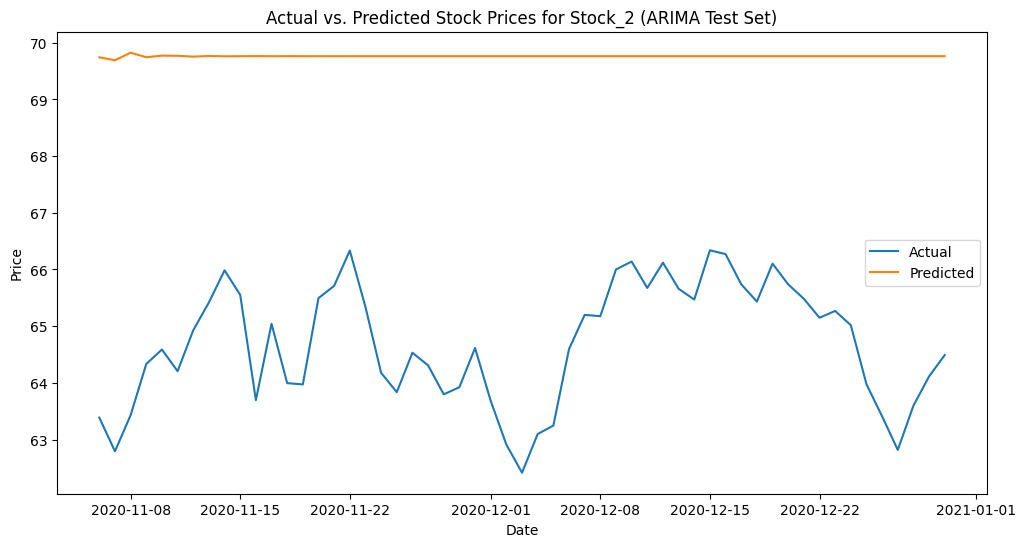

  Plotting for SARIMA...
    Re-running SARIMA prediction for plotting for Stock_2


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


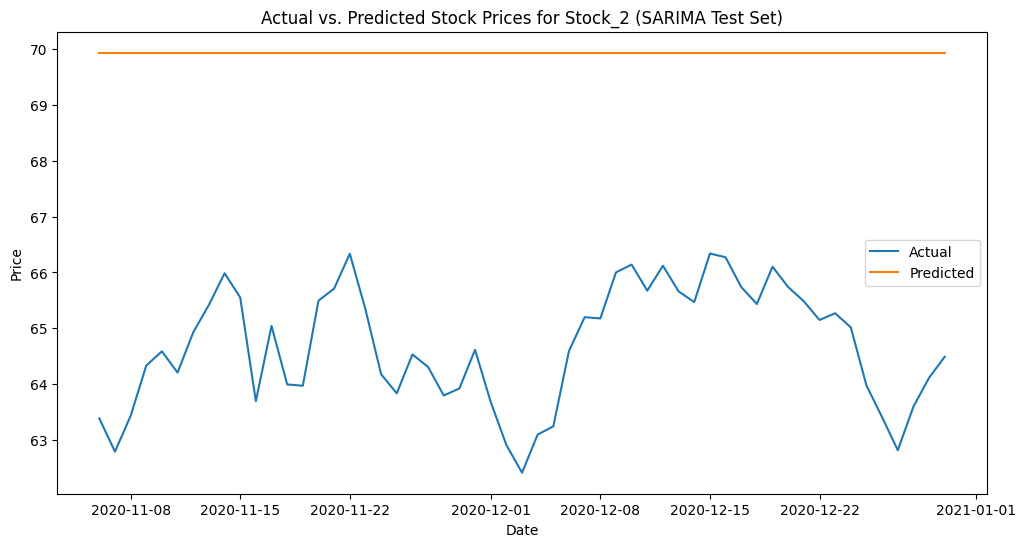

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgznpld1z/dq9nho6f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgznpld1z/j1ukeux9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48203', 'data', 'file=/tmp/tmpgznpld1z/dq9nho6f.json', 'init=/tmp/tmpgznpld1z/j1ukeux9.json', 'output', 'file=/tmp/tmpgznpld1z/prophet_modelfju62q9z/prophet_model-20250829173734.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


  Plotting for LSTM...
    Best model for Stock_2 is not LSTM, skipping LSTM plot.
  Plotting for Prophet...
    Re-running Prophet prediction for plotting for Stock_2


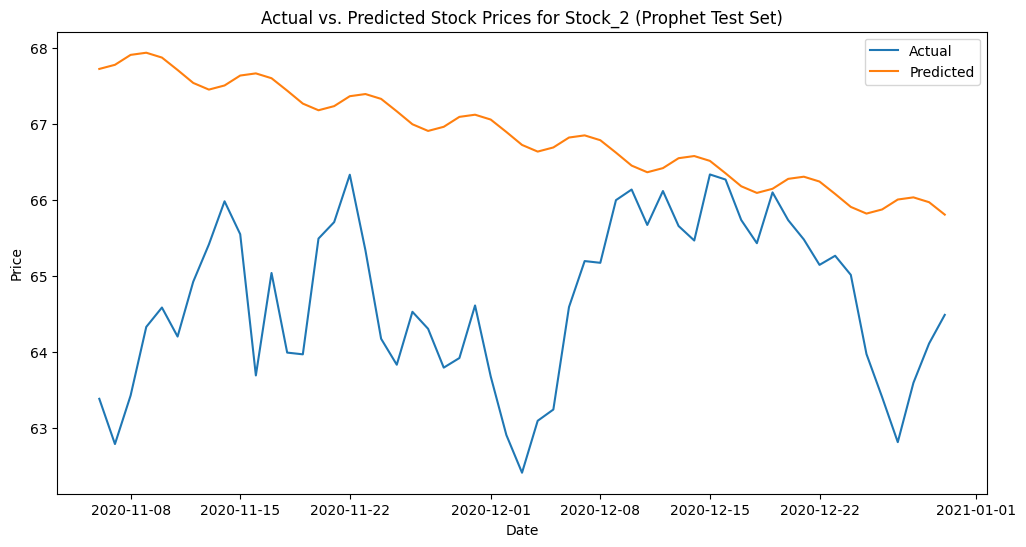

Plotting actual vs predicted for Stock_3 on test set...
  Plotting for ARIMA...
    Re-running ARIMA prediction for plotting for Stock_3


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


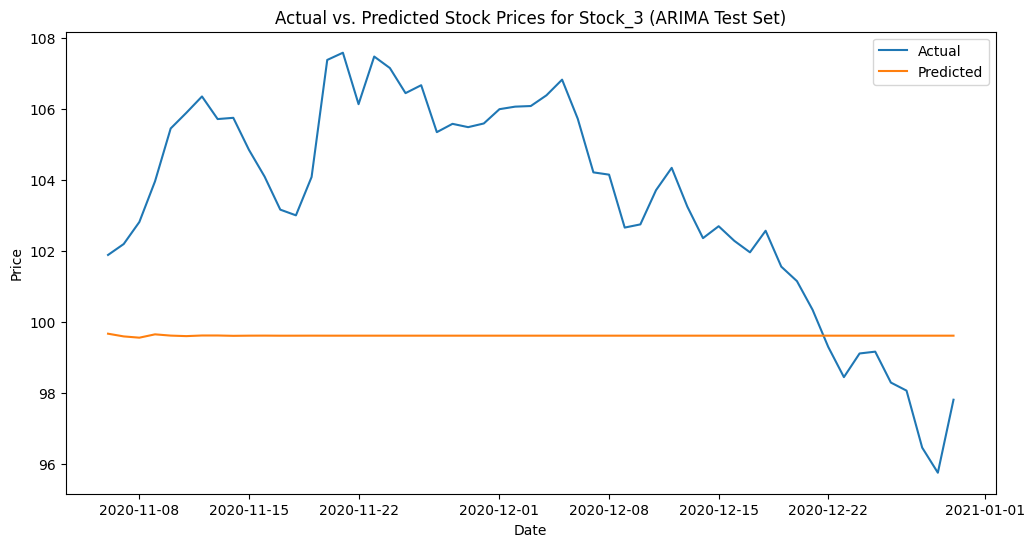

  Plotting for SARIMA...
    Re-running SARIMA prediction for plotting for Stock_3


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


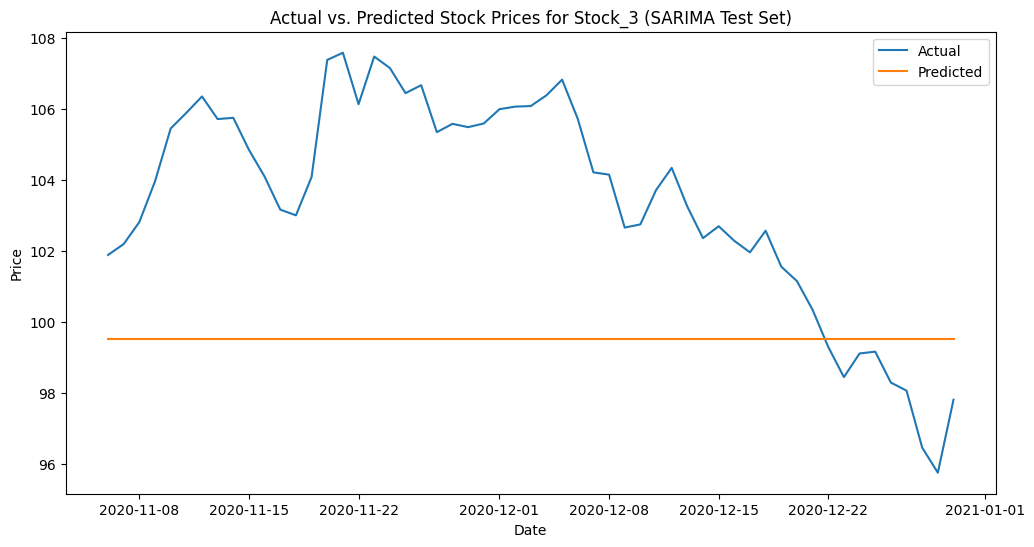

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgznpld1z/wtshkh5t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgznpld1z/qjdx_hlv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27597', 'data', 'file=/tmp/tmpgznpld1z/wtshkh5t.json', 'init=/tmp/tmpgznpld1z/qjdx_hlv.json', 'output', 'file=/tmp/tmpgznpld1z/prophet_modelocx9eeda/prophet_model-20250829173735.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


  Plotting for LSTM...
    Best model for Stock_3 is not LSTM, skipping LSTM plot.
  Plotting for Prophet...
    Re-running Prophet prediction for plotting for Stock_3


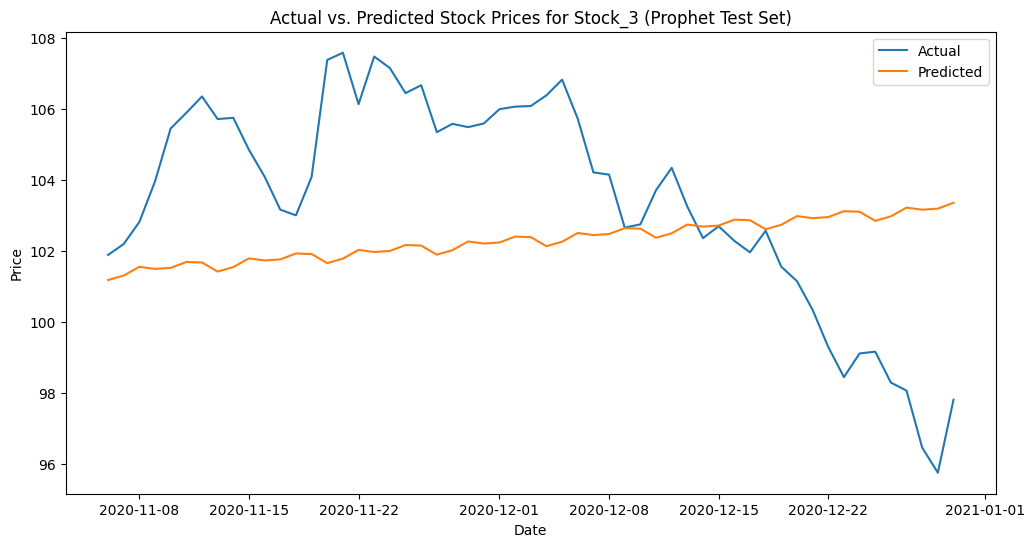

Plotting actual vs predicted for Stock_4 on test set...
  Plotting for ARIMA...
    Re-running ARIMA prediction for plotting for Stock_4


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


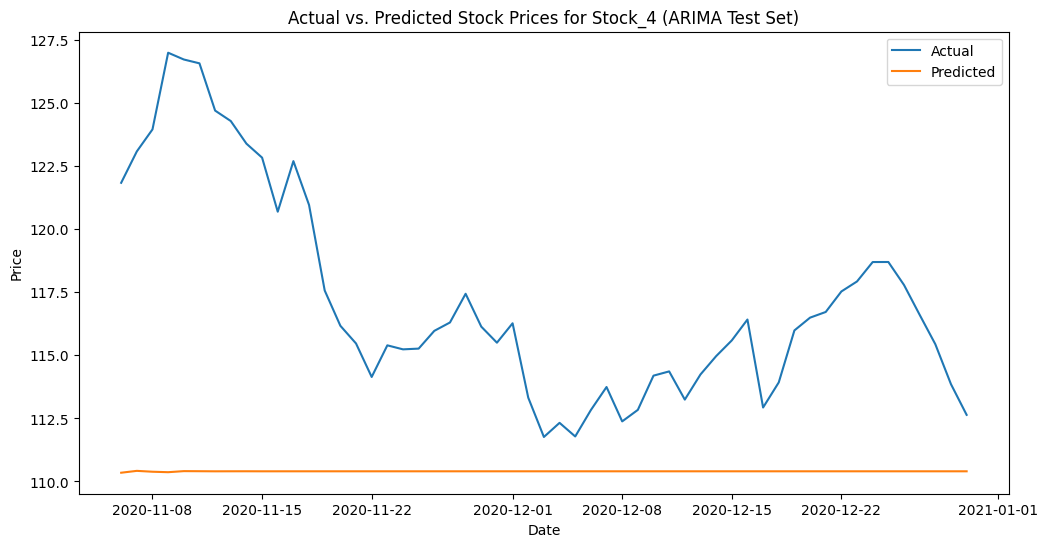

  Plotting for SARIMA...
    Re-running SARIMA prediction for plotting for Stock_4


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


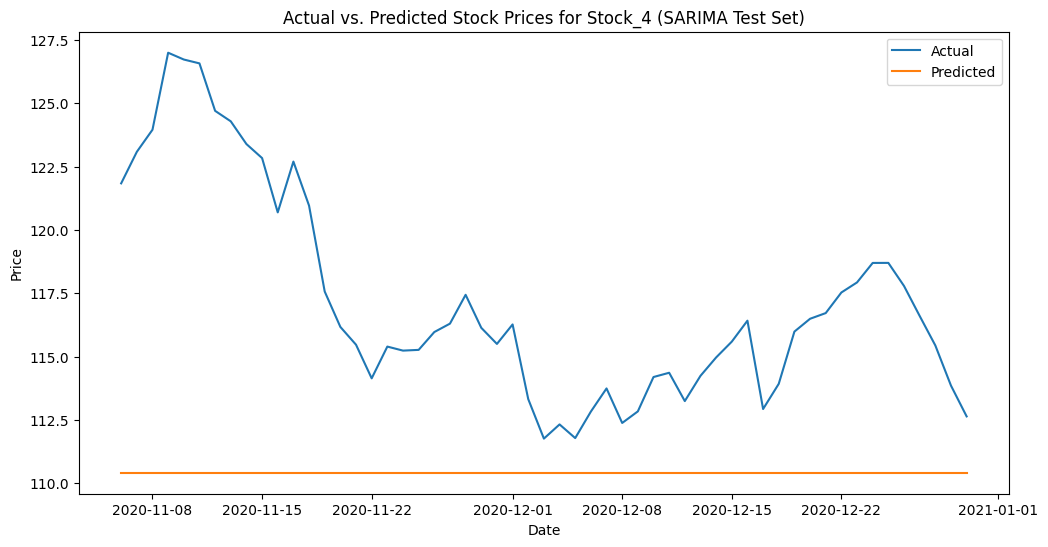

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgznpld1z/2deob54o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgznpld1z/rj_hbt67.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73013', 'data', 'file=/tmp/tmpgznpld1z/2deob54o.json', 'init=/tmp/tmpgznpld1z/rj_hbt67.json', 'output', 'file=/tmp/tmpgznpld1z/prophet_model1smz8vfk/prophet_model-20250829173736.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


  Plotting for LSTM...
    Best model for Stock_4 is not LSTM, skipping LSTM plot.
  Plotting for Prophet...
    Re-running Prophet prediction for plotting for Stock_4


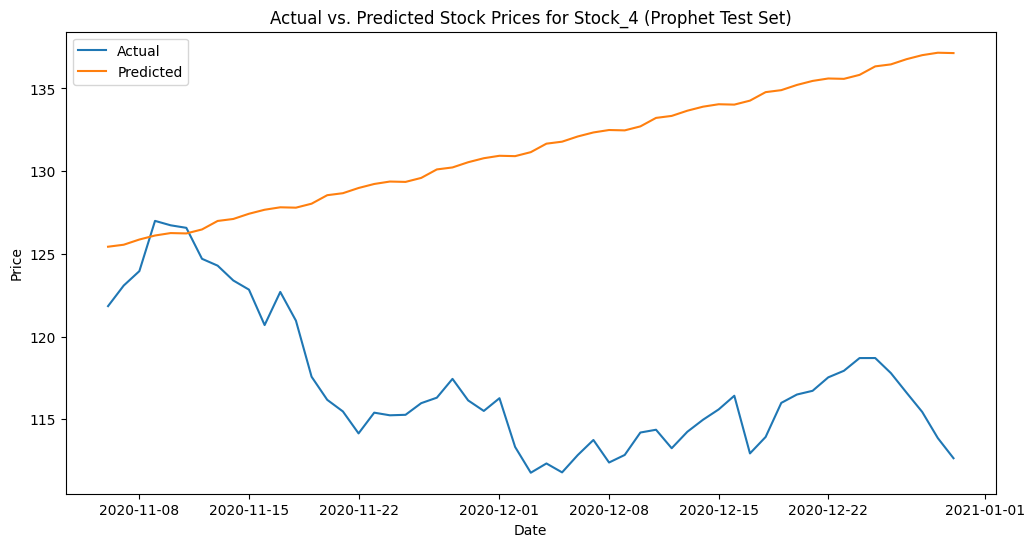

Plotting actual vs predicted for Stock_5 on test set...
  Plotting for ARIMA...
    Re-running ARIMA prediction for plotting for Stock_5


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


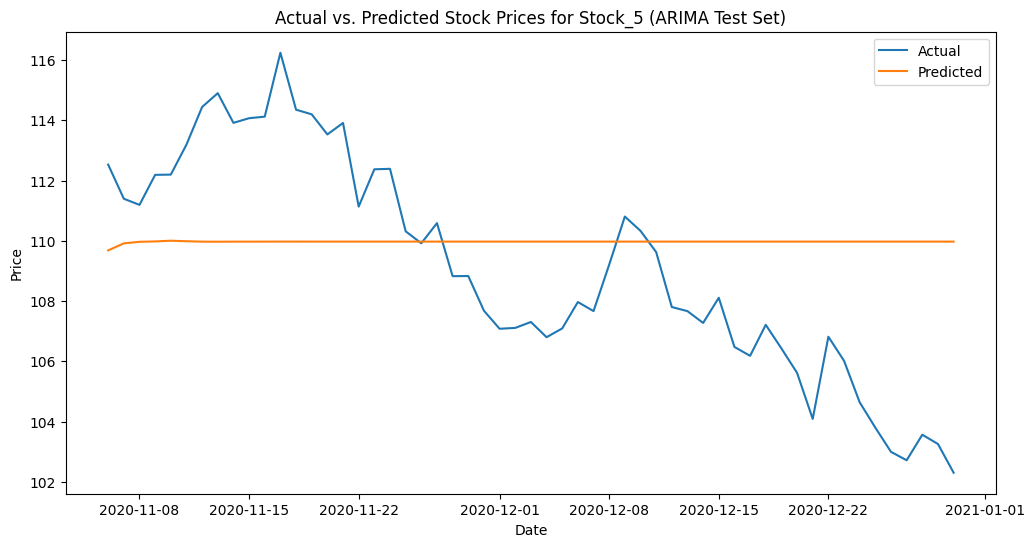

  Plotting for SARIMA...
    Re-running SARIMA prediction for plotting for Stock_5


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


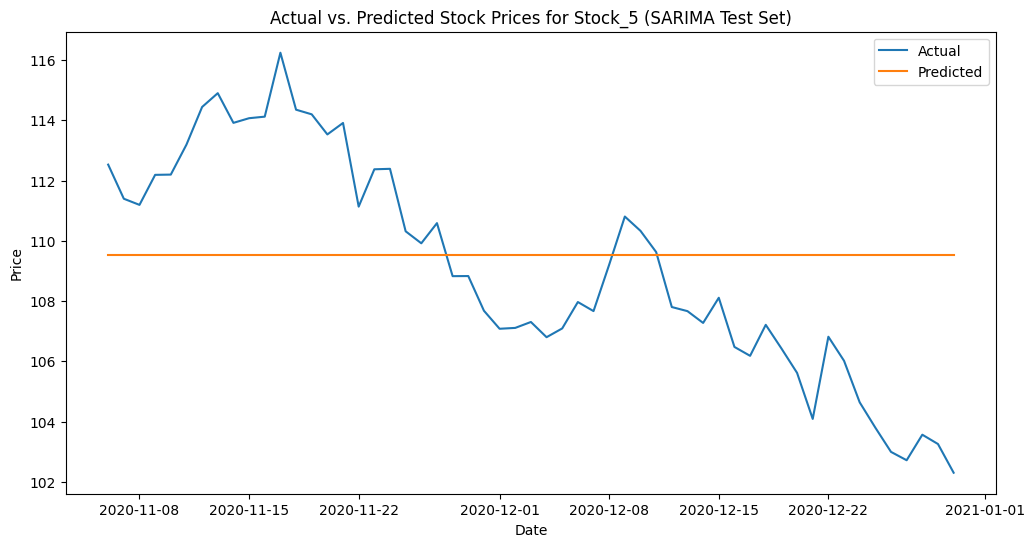

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgznpld1z/i0rtir4t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgznpld1z/czh1_dbs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96577', 'data', 'file=/tmp/tmpgznpld1z/i0rtir4t.json', 'init=/tmp/tmpgznpld1z/czh1_dbs.json', 'output', 'file=/tmp/tmpgznpld1z/prophet_model9wnyv9s8/prophet_model-20250829173737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


  Plotting for LSTM...
    Best model for Stock_5 is not LSTM, skipping LSTM plot.
  Plotting for Prophet...
    Re-running Prophet prediction for plotting for Stock_5


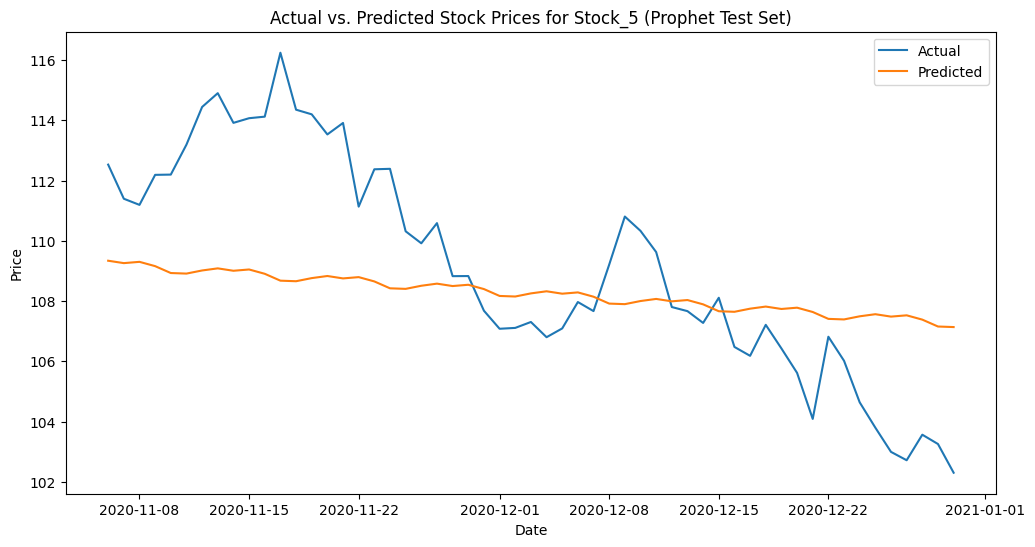

In [ ]:
# Plot actual vs predicted for each stock and traditional model on the test set
for stock in stocks:
    print(f"Plotting actual vs predicted for {stock} on test set...")

    # Iterate through the traditional models
    for model_name in ['ARIMA', 'SARIMA', 'LSTM', 'Prophet']:
        # Check if the model and stock exist in test_metrics
        if model_name in test_metrics and stock in test_metrics[model_name]:
            print(f"  Plotting for {model_name}...")

            # Retrieve actual test values
            actual = y_test[stock]

            # Retrieve predicted test values
            if model_name == 'LSTM':
                # Check if the best model for the current stock is LSTM
                best_model = final_models[stock]
                if isinstance(best_model, Sequential): # Check if the best model is a Keras Sequential model (LSTM)
                     print(f"    Using best trained LSTM model from final_models for {stock}")
                     # Make predictions using the best trained model
                     test_predictions_scaled = best_model.predict(X_test_seq[stock])
                     predicted_array = scalers[stock]['target'].inverse_transform(test_predictions_scaled)
                     # Align the index
                     aligned_y_test = y_test[stock].iloc[time_step:]
                     predicted = pd.Series(predicted_array.flatten(), index=aligned_y_test.index)

                     # Create a DataFrame for plotting for LSTM
                     # Ensure actual and predicted have the same index before creating DataFrame
                     common_index = actual.index.intersection(predicted.index)
                     plot_df = pd.DataFrame({'Actual': actual.loc[common_index], 'Predicted': predicted.loc[common_index]}, index=common_index)


                     # Plot the actual and predicted values
                     plt.figure(figsize=(12, 6))
                     plt.plot(plot_df['Actual'], label='Actual')
                     plt.plot(plot_df['Predicted'], label='Predicted')
                     plt.title(f'Actual vs. Predicted Stock Prices for {stock} ({model_name} Test Set)')
                     plt.xlabel('Date')
                     plt.ylabel('Price')
                     plt.legend()
                     plt.show()
                else:
                     print(f"    Best model for {stock} is not LSTM, skipping LSTM plot.")

            elif model_name == 'Prophet':
                # Re-run Prophet prediction within this loop as predictions were not stored persistently per stock
                print(f"    Re-running Prophet prediction for plotting for {stock}")
                # Prepare training data for Prophet (using combined train and validation)
                prophet_train_df = prophet_data[stock].iloc[:train_size + val_size]

                # Instantiate and fit Prophet model
                model = Prophet()
                model.fit(prophet_train_df)

                # Create future dataframe for prediction using the index of the test set
                future = pd.DataFrame({'ds': y_test[stock].index})

                # Make predictions
                forecast = model.predict(future)

                # Extract predictions for the test period and align with actual test data
                predicted = forecast.set_index('ds')['yhat']
                predicted.index = pd.to_datetime(predicted.index) # Ensure index is datetime

                # Create a DataFrame for plotting for Prophet
                # Ensure actual and predicted have the same index before creating DataFrame
                common_index = actual.index.intersection(predicted.index)
                plot_df = pd.DataFrame({'Actual': actual.loc[common_index], 'Predicted': predicted.loc[common_index]}, index=common_index)

                # Plot the actual and predicted values
                plt.figure(figsize=(12, 6))
                plt.plot(plot_df['Actual'], label='Actual')
                plt.plot(plot_df['Predicted'], label='Predicted')
                plt.title(f'Actual vs. Predicted Stock Prices for {stock} ({model_name} Test Set)')
                plt.xlabel('Date')
                plt.ylabel('Price')
                plt.legend()
                plt.show()


            else: # ARIMA and SARIMA
                 # Re-running prediction step as predictions were not stored persistently per stock
                 if model_name == 'ARIMA':
                    # Re-running ARIMA prediction:
                    print(f"    Re-running ARIMA prediction for plotting for {stock}")
                    order = (5, d_order[stock], 0)
                    model = ARIMA(y_train[stock], order=order)
                    model_fit = model.fit()
                    start_index = len(y_train[stock])
                    end_index = len(y_train[stock]) + len(y_test[stock]) - 1
                    predicted = model_fit.predict(start=start_index, end=end_index)
                    predicted.index = y_test[stock].index # Align index

                 elif model_name == 'SARIMA':
                     # Re-running SARIMA prediction:
                     print(f"    Re-running SARIMA prediction for plotting for {stock}")
                     order = (1, d_order[stock], 0)
                     seasonal_order = (1, 0, 0, 7)
                     model = SARIMAX(y_train[stock], order=order, seasonal_order=seasonal_order)
                     model_fit = model.fit()
                     start_index = y_test[stock].index[0]
                     end_index = y_test[stock].index[-1]
                     predicted = model_fit.predict(start=start_index, end=end_index)

                 # Ensure actual and predicted have the same index before creating DataFrame for ARIMA/SARIMA
                 common_index = actual.index.intersection(predicted.index)
                 actual_aligned = actual.loc[common_index]
                 predicted_aligned = predicted.loc[common_index]
                 plot_df = pd.DataFrame({'Actual': actual_aligned, 'Predicted': predicted_aligned}, index=common_index)
                 # Plot the actual and predicted values
                 plt.figure(figsize=(12, 6))
                 plt.plot(plot_df['Actual'], label='Actual')
                 plt.plot(plot_df['Predicted'], label='Predicted')
                 plt.title(f'Actual vs. Predicted Stock Prices for {stock} ({model_name} Test Set)')
                 plt.xlabel('Date')
                 plt.ylabel('Price')
                 plt.legend()
                 plt.show()

## Summary:

### Data Analysis Key Findings

*   All stock price series were initially non-stationary, requiring first-order differencing (d=1) to achieve stationarity for ARIMA/SARIMA modeling.
*   Based on RMSE, the Naive Last-Value Baseline performed best for four out of the five stocks (Stock_1, Stock_2, Stock_4, and Stock_5).
*   For Stock_3, the best performing model based on RMSE was the Best Regression model (Ridge).
*   The more complex traditional forecasting models (ARIMA, SARIMA, LSTM, Prophet) generally exhibited higher RMSE values on the test set compared to the baselines and the best regression models in this specific analysis.
*   Visualizations of actual vs. predicted values for ARIMA, SARIMA, LSTM (where it was the best model), and Prophet models on the test set were generated, allowing for a qualitative assessment of their forecasting performance.



Future Prediction using Gradient Boosting Regressor


Use the Gradient Boosting Regressor model to forecast stock prices for the next month for all stocks, generating future features with a simplifying assumption.

**Reasoning**:
Train the Gradient Boosting Regressor model on the full dataset for each stock. Generate future features for the forecast period, using the last known non-time features as a simplification. Use the trained model and future features to generate predictions for the next month. Finally, visualize the predicted values along with the historical data.

Full dataset and scaler preparation complete.

Generating future predictions for Stock_1 using LSTM...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitte


Generating future predictions for Stock_2 using LSTM...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/valida


Generating future predictions for Stock_3 using LSTM...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/valida


Generating future predictions for Stock_4 using LSTM...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/valida


Generating future predictions for Stock_5 using LSTM...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/valida


Future Stock Price Predictions (LSTM) for the Next Month:

Predictions for Stock_1:


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


,0
2020-12-31,92.345512
2021-01-01,92.518379
2021-01-02,93.232452
2021-01-03,94.093147
2021-01-04,95.070885
2021-01-05,96.287384
2021-01-06,97.514450
2021-01-07,98.738518
2021-01-08,100.242218
2021-01-09,101.638199



Predictions for Stock_2:


,0
2020-12-31,64.219048
2021-01-01,64.255836
2021-01-02,64.685600
2021-01-03,65.525421
2021-01-04,66.609039
2021-01-05,67.850021
2021-01-06,69.153152
2021-01-07,70.464790
2021-01-08,72.144165
2021-01-09,73.695847



Predictions for Stock_3:


,0
2020-12-31,97.151649
2021-01-01,96.719040
2021-01-02,97.631027
2021-01-03,99.040535
2021-01-04,100.466965
2021-01-05,101.614334
2021-01-06,102.410622
2021-01-07,102.794167
2021-01-08,102.873230
2021-01-09,102.637566



Predictions for Stock_4:


,0
2020-12-31,115.160652
2021-01-01,114.889587
2021-01-02,114.580162
2021-01-03,114.102051
2021-01-04,113.652687
2021-01-05,112.997055
2021-01-06,112.261864
2021-01-07,111.487892
2021-01-08,111.040916
2021-01-09,110.463722



Predictions for Stock_5:


,0
2020-12-31,103.073219
2021-01-01,102.996269
2021-01-02,102.697327
2021-01-03,102.419548
2021-01-04,102.124924
2021-01-05,101.654167
2021-01-06,100.937447
2021-01-07,100.086136
2021-01-08,99.248055
2021-01-09,98.339088



Visualizing Future Predictions (LSTM):


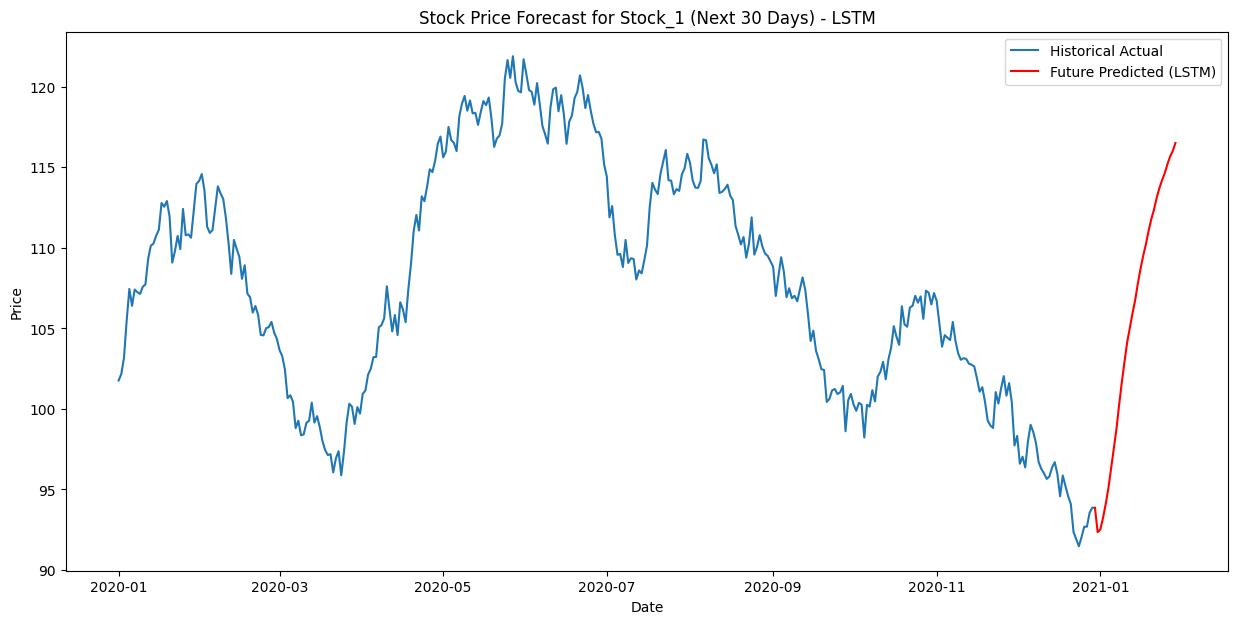

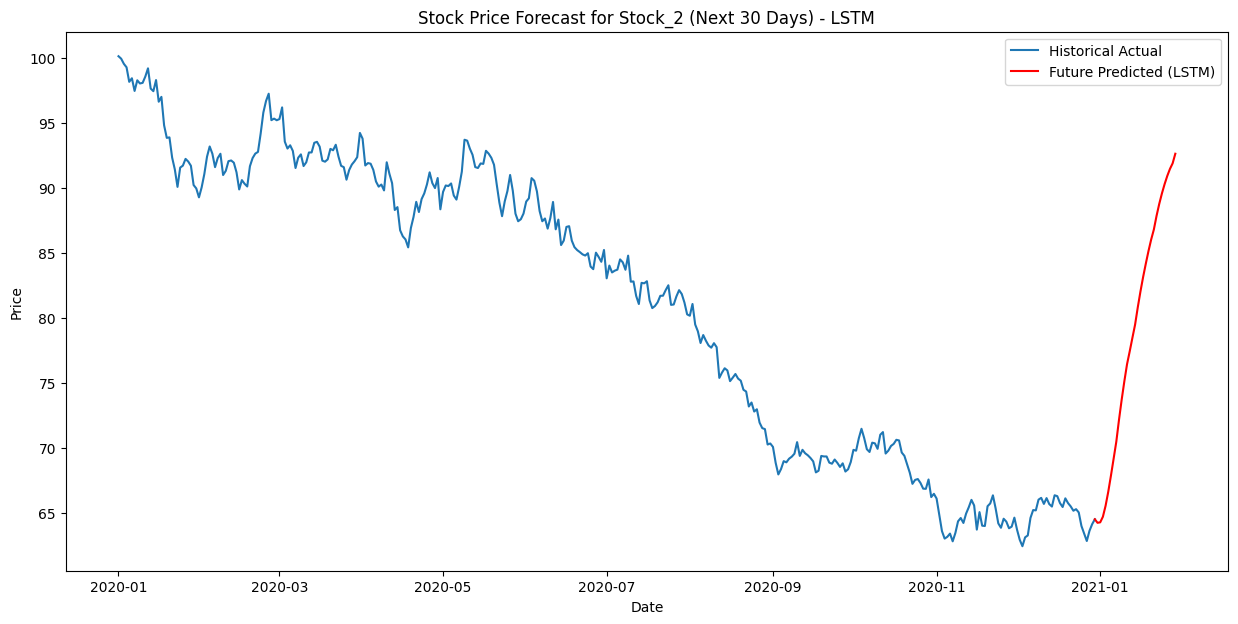

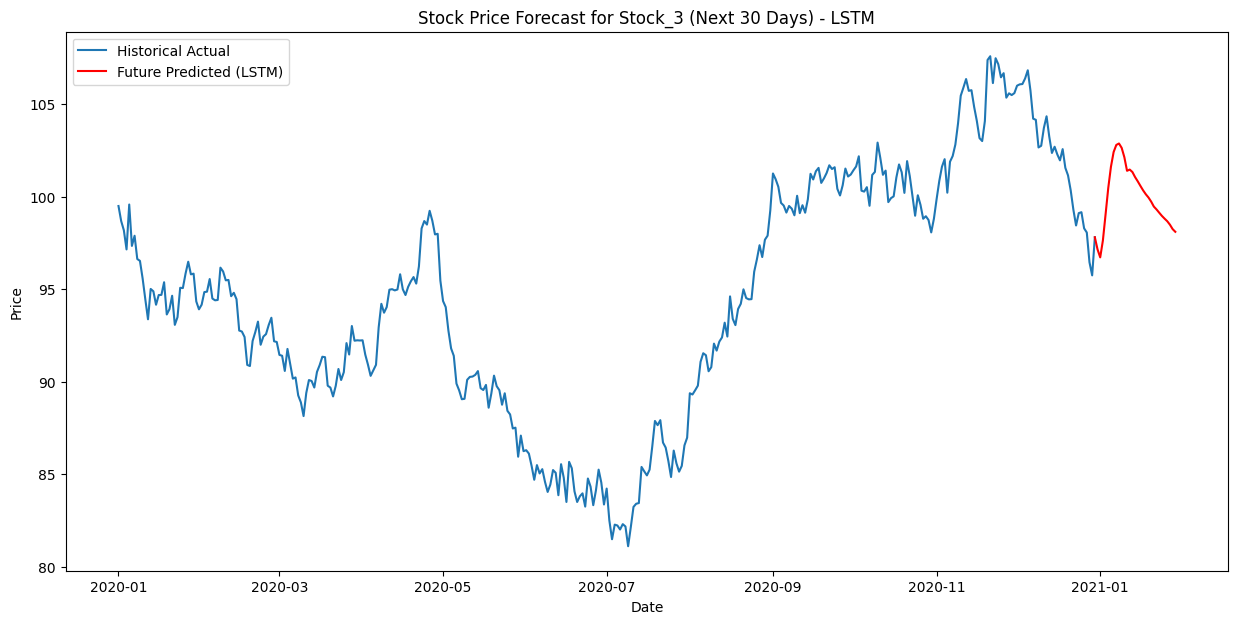

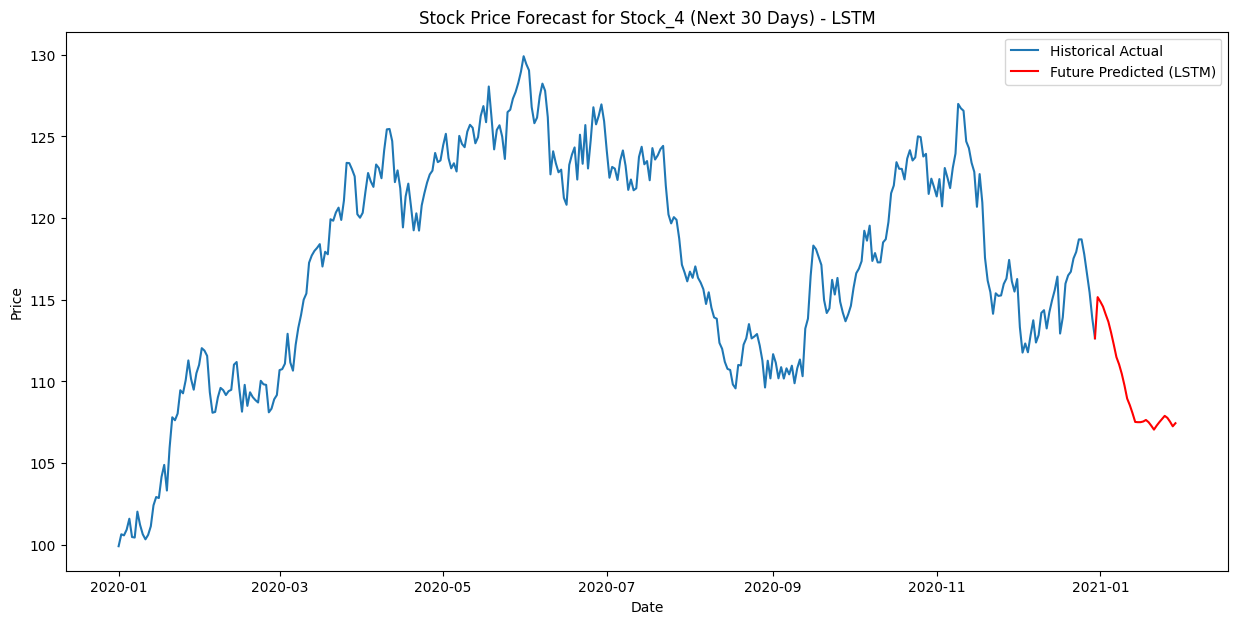

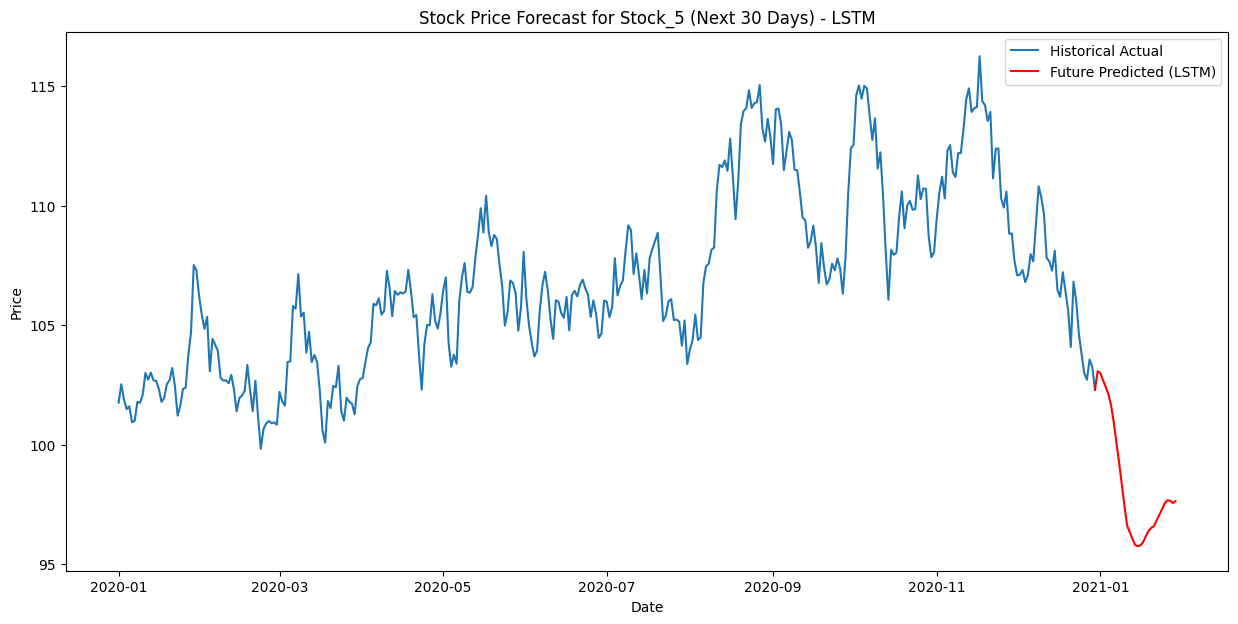

In [ ]:
# Define the create_sequences function (needed for LSTM)
def create_sequences(X, y, time_step=1):
    """
    Create sequences from features (X) and target (y) for time series forecasting.

    Args:
        X (np.ndarray): Feature data (scaled).
        y (np.ndarray): Target data (scaled).
        time_step (int): The number of previous time steps to use as input features.

    Returns:
        tuple: A tuple containing:
            - X_seq (np.ndarray): Sequences of input features.
            - y_seq (np.ndarray): Corresponding target values.
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - time_step):
        # Extract sequence of features (X values)
        X_seq.append(X[i:(i + time_step), :])
        # Extract the target value (y value at the end of the sequence)
        y_seq.append(y[i + time_step, 0]) # Assuming y is 2D (samples, 1) and we need the value

    return np.array(X_seq), np.array(y_seq)


# Determine the last date in the dataset
last_date = df.index[-1]

# Define the number of days to forecast (approximately one month)
forecast_period_days = 30

# Create a date range for the forecast period
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_period_days, freq='D')

# Initialize a dictionary to store future predictions
lstm_future_predictions = {}

# Prepare full feature dataset and scaler for each stock (needed for training and feature generation)
df_full_features_stocks = {}
full_feature_scalers = {}
X_full_scaled_stocks = {} # Store scaled full features for LSTM sequence creation
y_full_scaled_stocks = {} # Store scaled full targets
full_scalers = {} # Initialize full_scalers dictionary here

for stock in stocks:
    df_full_features_stock = pd.DataFrame(index=df.index)
    # Create lag features (lags 1 to 5)
    for i in range(1, 6):
        df_full_features_stock[f'{stock}_lag_{i}'] = df[stock].shift(i)
    # Calculate expanding mean, EMA, and volatility
    df_full_features_stock[f'{stock}_expanding_mean'] = df[stock].expanding(min_periods=1).mean().shift(1)
    df_full_features_stock[f'{stock}_expanding_ema'] = df[stock].ewm(alpha=0.05, adjust=False, min_periods=1).mean().shift(1)
    df_full_features_stock[f'{stock}_expanding_std'] = df[stock].expanding(min_periods=1).std().shift(1)
    # Extract time-based features
    df_full_features_stock['day_of_week'] = df_full_features_stock.index.dayofweek
    df_full_features_stock['month'] = df_full_features_stock.index.month
    df_full_features_stock['day_of_year'] = df_full_features_stock.index.dayofyear
    df_full_features_stock['quarter'] = df_full_features_stock.index.quarter
    # Create Fourier features (2 pairs of sine and cosine)
    for k in range(1, 3):
        df_full_features_stock[f'sin_{k}'] = np.sin(2 * np.pi * k * df_full_features_stock['day_of_year'] / 365.25)
        df_full_features_stock[f'cos_{k}'] = np.cos(2 * np.pi * k * df_full_features_stock['day_of_year'] / 365.25)

    # Drop rows with NaN values (due to lag features)
    df_full_features_stock_cleaned = df_full_features_stock.dropna()
    actual_full_cleaned = df[stock].loc[df_full_features_stock_cleaned.index]

    df_full_features_stocks[stock] = df_full_features_stock_cleaned

    # Fit scaler on the full features and target
    full_feature_scaler = MinMaxScaler()
    full_target_scaler = MinMaxScaler()
    X_full_scaled = full_feature_scaler.fit_transform(df_full_features_stock_cleaned)
    y_full_scaled = full_target_scaler.fit_transform(actual_full_cleaned.values.reshape(-1, 1))

    full_feature_scalers[stock] = full_feature_scaler # Store feature scaler
    full_scalers[stock] = {'features': full_feature_scaler, 'target': full_target_scaler} # Store both scalers

    X_full_scaled_stocks[stock] = X_full_scaled # Store scaled full features
    y_full_scaled_stocks[stock] = y_full_scaled # Store scaled full targets


print("Full dataset and scaler preparation complete.")


# Train and forecast using LSTM for each stock
for stock in stocks:
    print(f"\nGenerating future predictions for {stock} using LSTM...")

    # Get the full cleaned features and actual values for the current stock
    X_full_cleaned = df_full_features_stocks[stock]
    y_full_cleaned = df[stock].loc[X_full_cleaned.index]
    X_full_scaled = X_full_scaled_stocks[stock]
    y_full_scaled = y_full_scaled_stocks[stock] # Get scaled full targets
    full_target_scaler = full_scalers[stock]['target']
    full_feature_scaler = full_scalers[stock]['features']


    # Create sequences for the full dataset using scaled data
    time_step = 10 # Use the same time_step as before for consistency
    X_full_seq, y_full_seq = create_sequences(X_full_scaled, y_full_scaled, time_step) # Create sequences from scaled data


    # Define and train the LSTM model on the full dataset
    n_features = X_full_seq.shape[2]
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, n_features)))
    lstm_model.add(LSTM(units=50))
    lstm_model.add(Dense(units=1))
    lstm_model.compile(optimizer='adam', loss='mean_squared_error')
    lstm_model.fit(X_full_seq, y_full_seq, epochs=50, batch_size=32, verbose=0) # Train with scaled target


    # --- Generate future predictions iteratively ---
    # Use the last 'time_step' feature vectors from the full scaled data as the initial input sequence
    last_time_step_features_scaled = X_full_scaled[-time_step:]
    future_preds_scaled = []
    # Reshape the initial sequence to have a batch size of 1
    current_input_sequence_scaled = last_time_step_features_scaled.reshape(1, time_step, n_features)


    # Get the last known features (unscaled) to help with iterative feature generation
    last_known_features_unscaled = df_full_features_stocks[stock].iloc[-1].copy()

    for i in range(forecast_period_days):
        # Reshape the current sequence for prediction (add batch dimension) - already done above

        # Predict the next value (scaled)
        next_pred_scaled = lstm_model.predict(current_input_sequence_scaled, verbose=0)
        predicted_scaled_value = next_pred_scaled[0, 0]
        future_preds_scaled.append(predicted_scaled_value)

        # --- Prepare the feature vector for the next time step (next iteration) ---
        # Inverse transform the predicted scaled value to get the predicted price
        predicted_unscaled_value = full_target_scaler.inverse_transform(next_pred_scaled)[0, 0]

        # Create a pandas Series from the last known unscaled features to easily shift
        last_known_features_series = last_known_features_unscaled.copy()

        # Create the new feature vector for the next date (forecast_dates[i])
        next_date = forecast_dates[i]
        next_features_unscaled = pd.Series(index=last_known_features_series.index)

        # Generate time features for the next date - Corrected access using next_date
        next_features_unscaled['day_of_week'] = next_date.dayofweek
        next_features_unscaled['month'] = next_date.month
        next_features_unscaled['day_of_year'] = next_date.dayofyear
        next_features_unscaled['quarter'] = next_date.quarter
        for k in range(1, 3):
            next_features_unscaled[f'sin_{k}'] = np.sin(2 * np.pi * k * next_date.dayofyear / 365.25) # Corrected
            next_features_unscaled[f'cos_{k}'] = np.cos(2 * np.pi * k * next_date.dayofyear / 365.25) # Corrected

        # Update lag features using the predicted unscaled value
        next_features_unscaled[f'{stock}_lag_1'] = predicted_unscaled_value
        for lag in range(2, 6):
            # Need to get the previous lag features from the last_known_features_unscaled Series
            # Assuming last_known_features_unscaled holds the features for the *previous* date
            next_features_unscaled[f'{stock}_lag_{lag}'] = last_known_features_series[f'{stock}_lag_{lag-1}']

        # Carry forward expanding features (simplification)
        next_features_unscaled[f'{stock}_expanding_mean'] = last_known_features_series[f'{stock}_expanding_mean']
        next_features_unscaled[f'{stock}_expanding_ema'] = last_known_features_series[f'{stock}_expanding_ema']
        next_features_unscaled[f'{stock}_expanding_std'] = last_known_features_series[f'{stock}_expanding_std']

        # Update last_known_features_unscaled for the next iteration
        last_known_features_unscaled = next_features_unscaled.copy()


        # Scale the new feature vector using the feature scaler
        next_features_scaled = full_feature_scaler.transform(next_features_unscaled.values.reshape(1, -1))

        # Update the current input sequence: remove the oldest feature vector and add the new one
        # The new feature vector needs to be in the correct shape (1, 1, n_features)
        current_input_sequence_scaled = np.append(current_input_sequence_scaled[:, 1:, :], next_features_scaled.reshape(1, 1, n_features), axis=1)


    # Inverse transform the scaled future predictions
    future_preds_unscaled = full_target_scaler.inverse_transform(np.array(future_preds_scaled).reshape(-1, 1))

    # Create a pandas Series for future predictions with the forecast dates
    lstm_future_predictions[stock] = pd.Series(future_preds_unscaled.flatten(), index=forecast_dates)

# Display the future predictions for each stock
print("\nFuture Stock Price Predictions (LSTM) for the Next Month:")
for stock, preds in lstm_future_predictions.items():
    print(f"\nPredictions for {stock}:")
    display(preds)

# Visualize the future predictions along with the historical data
print("\nVisualizing Future Predictions (LSTM):")
for stock, preds in lstm_future_predictions.items():
    plt.figure(figsize=(15, 7))
    # Plot historical data
    plt.plot(df[stock], label='Historical Actual')
    # Plot future predictions, starting from the last historical date to connect the lines
    # We need to include the last historical point in the prediction plot to make it continuous
    combined_preds = pd.concat([df[stock].tail(1), preds])
    plt.plot(combined_preds.index, combined_preds, label='Future Predicted (LSTM)', color='red')
    plt.title(f'Stock Price Forecast for {stock} (Next {forecast_period_days} Days) - LSTM')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

## Future Prediction using Prophet


Use the Prophet model to forecast stock prices for the next month for all stocks and visualize the results.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgznpld1z/4vctqmj7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgznpld1z/lfo3awv6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20028', 'data', 'file=/tmp/tmpgznpld1z/4vctqmj7.json', 'init=/tmp/tmpgznpld1z/lfo3awv6.json', 'output', 'file=/tmp/tmpgznpld1z/prophet_modelz00qgyjr/prophet_model-20250829174140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:41:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



Generating future predictions for Stock_1 using Prophet...


17:41:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgznpld1z/455vy_7x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgznpld1z/mld91_vg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71600', 'data', 'file=/tmp/tmpgznpld1z/455vy_7x.json', 'init=/tmp/tmpgznpld1z/mld91_vg.json', 'output', 'file=/tmp/tmpgznpld1z/prophet_modelefl4dyme/prophet_model-20250829174140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:41:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



Generating future predictions for Stock_2 using Prophet...


17:41:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgznpld1z/x3gr7mfy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgznpld1z/tzsqbf60.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58411', 'data', 'file=/tmp/tmpgznpld1z/x3gr7mfy.json', 'init=/tmp/tmpgznpld1z/tzsqbf60.json', 'output', 'file=/tmp/tmpgznpld1z/prophet_model2dtu0fw0/prophet_model-20250829174141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:41:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:41:41 - cmdstanpy - INFO - Chain [1] 


Generating future predictions for Stock_3 using Prophet...


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgznpld1z/_6wjn06t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgznpld1z/9wnrysyj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25645', 'data', 'file=/tmp/tmpgznpld1z/_6wjn06t.json', 'init=/tmp/tmpgznpld1z/9wnrysyj.json', 'output', 'file=/tmp/tmpgznpld1z/prophet_model_io2hnri/prophet_model-20250829174141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:41:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:41:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Generating future predictions for Stock_4 using Prophet...


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgznpld1z/vfgp3ik5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgznpld1z/ymjnw0oc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76040', 'data', 'file=/tmp/tmpgznpld1z/vfgp3ik5.json', 'init=/tmp/tmpgznpld1z/ymjnw0oc.json', 'output', 'file=/tmp/tmpgznpld1z/prophet_modelc9wz7a6z/prophet_model-20250829174141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:41:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:41:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Generating future predictions for Stock_5 using Prophet...

Future Stock Price Predictions (Prophet) for the Next Month:

Predictions for Stock_1:


,yhat
2020-12-31,93.543031
2021-01-01,93.596850
2021-01-02,93.497662
2021-01-03,93.283955
2021-01-04,92.957998
2021-01-05,92.329690
2021-01-06,92.324698
2021-01-07,92.403974
2021-01-08,92.457793
2021-01-09,92.358605



Predictions for Stock_2:


,yhat
2020-12-31,63.193585
2021-01-01,63.127170
2021-01-02,63.169158
2021-01-03,63.241902
2021-01-04,63.216250
2021-01-05,63.135438
2021-01-06,62.955917
2021-01-07,62.781222
2021-01-08,62.714807
2021-01-09,62.756796



Predictions for Stock_3:


,yhat
2020-12-31,103.065243
2021-01-01,102.923427
2021-01-02,103.008137
2021-01-03,103.080597
2021-01-04,102.979628
2021-01-05,102.980333
2021-01-06,103.089916
2021-01-07,103.160285
2021-01-08,103.018469
2021-01-09,103.103179



Predictions for Stock_4:


,yhat
2020-12-31,113.755300
2021-01-01,113.906919
2021-01-02,113.746323
2021-01-03,113.665042
2021-01-04,113.665966
2021-01-05,113.511807
2021-01-06,113.161156
2021-01-07,112.965795
2021-01-08,113.117415
2021-01-09,112.956819



Predictions for Stock_5:


,yhat
2020-12-31,106.824132
2021-01-01,106.852493
2021-01-02,106.635030
2021-01-03,106.582008
2021-01-04,106.457766
2021-01-05,106.378496
2021-01-06,106.231571
2021-01-07,106.393596
2021-01-08,106.421957
2021-01-09,106.204494



Visualizing Future Predictions (Prophet):


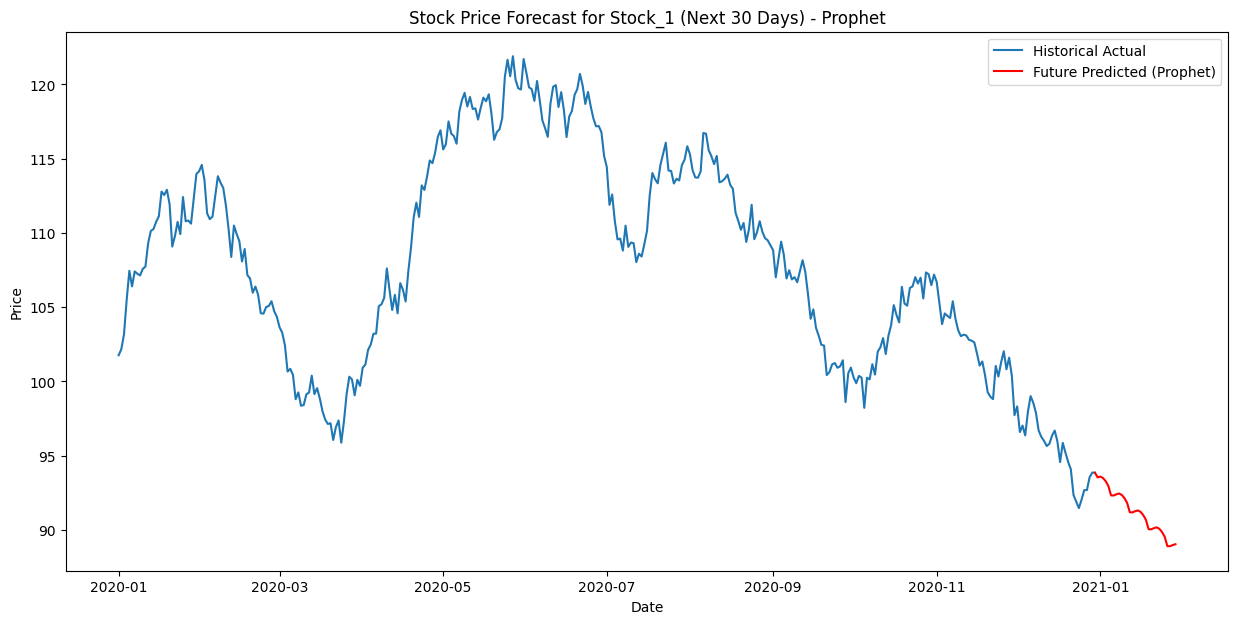

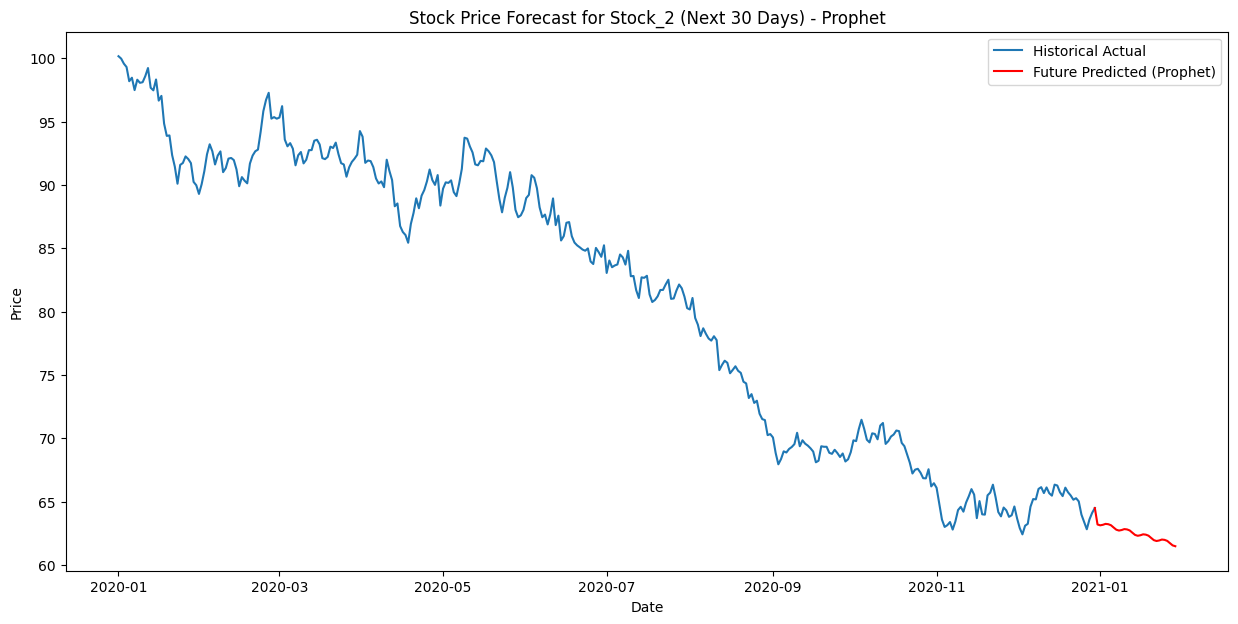

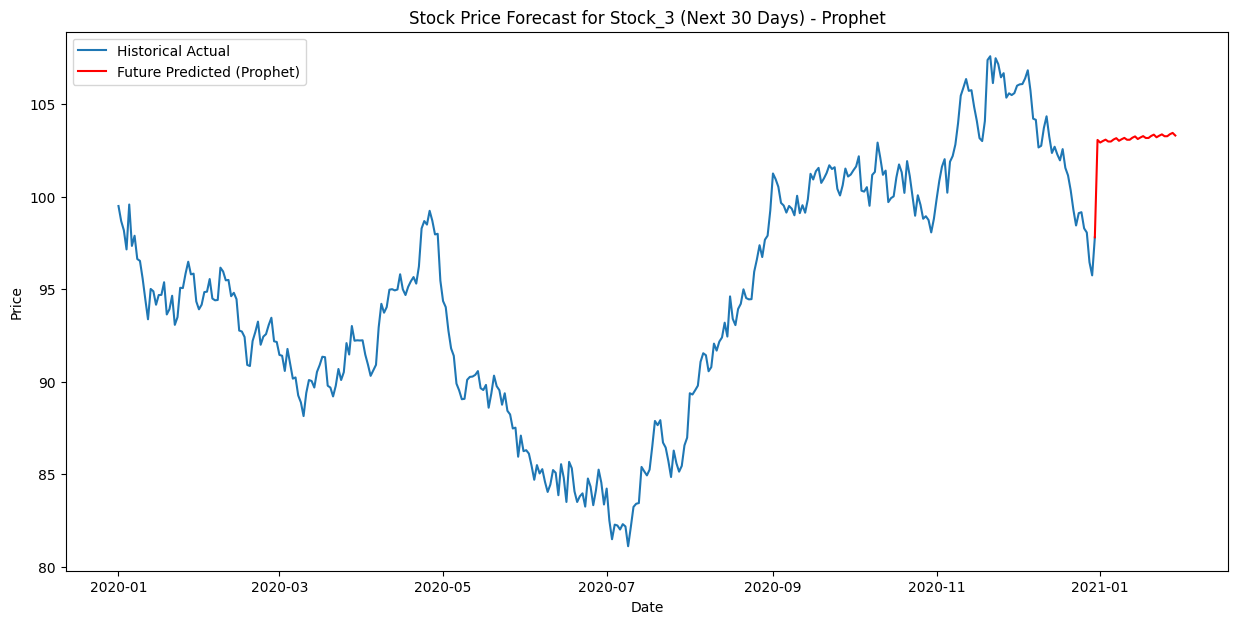

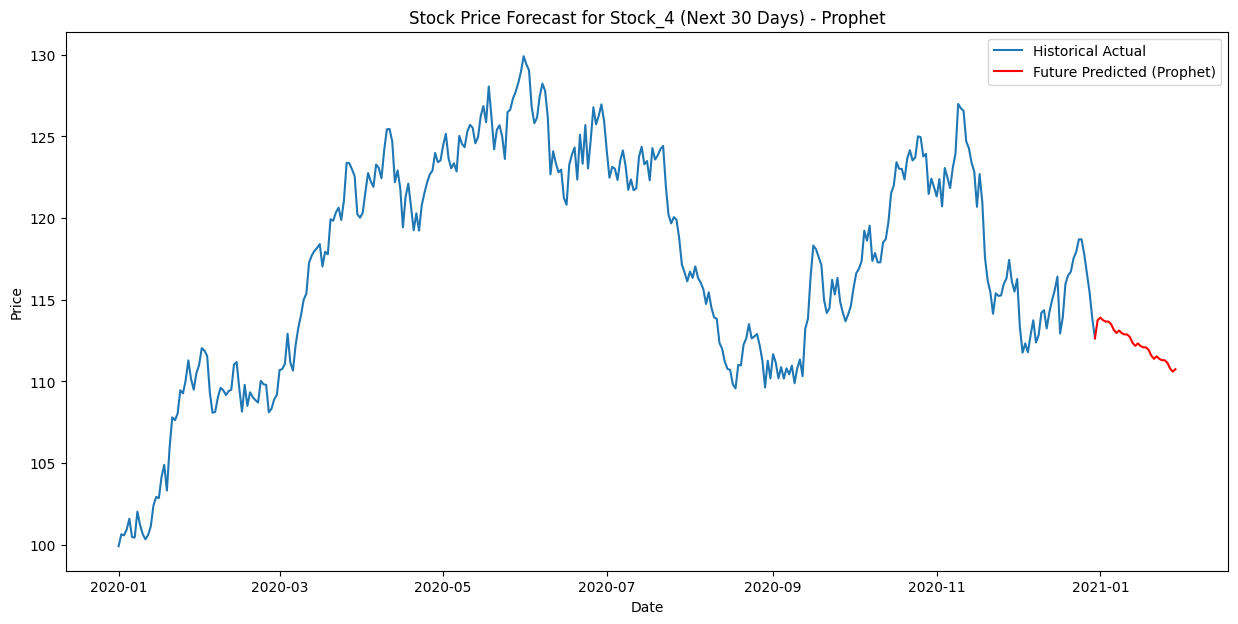

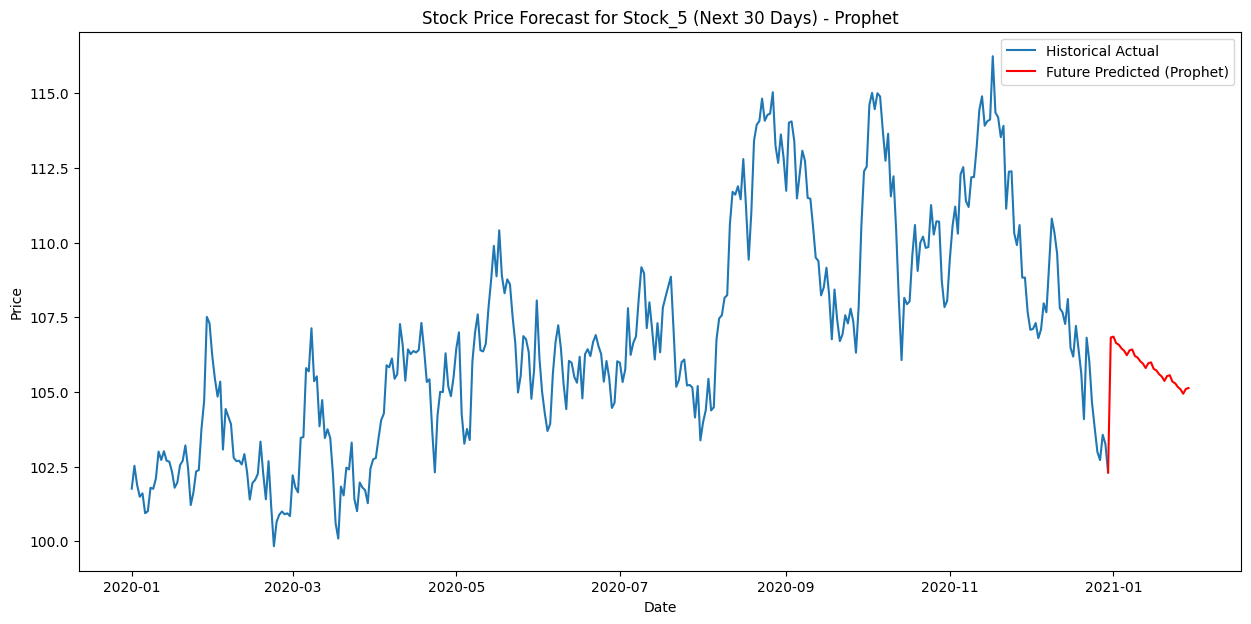

In [ ]:
# Determine the last date in the dataset
last_date = df.index[-1]

# Define the number of days to forecast (approximately one month)
forecast_period_days = 30

# Create a date range for the forecast period (for plotting later)
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_period_days, freq='D')


# Initialize a dictionary to store future predictions from Prophet
prophet_future_predictions = {}

# Train and forecast using Prophet for each stock
for stock in stocks:
    print(f"\nGenerating future predictions for {stock} using Prophet...")

    # Prepare data for Prophet: requires 'ds' (datetime) and 'y' (target) columns
    prophet_df = df[[stock]].reset_index()
    prophet_df.columns = ['ds', 'y']

    # Instantiate and train the Prophet model on the full data
    model = Prophet()
    model.fit(prophet_df)

    # Create a future dataframe for the forecast period
    future = model.make_future_dataframe(periods=forecast_period_days, freq='D')

    # Make predictions on the future dataframe
    forecast = model.predict(future)

    # Extract the forecast for the future dates
    future_preds = forecast.set_index('ds')['yhat'].loc[forecast_dates]
    future_preds.index = forecast_dates # Ensure index is correct


    # Store the future predictions
    prophet_future_predictions[stock] = future_preds

# Display the future predictions for each stock
print("\nFuture Stock Price Predictions (Prophet) for the Next Month:")
for stock, preds in prophet_future_predictions.items():
    print(f"\nPredictions for {stock}:")
    display(preds)

# Visualize the future predictions along with the historical data
print("\nVisualizing Future Predictions (Prophet):")
for stock, preds in prophet_future_predictions.items():
    plt.figure(figsize=(15, 7))
    # Plot historical data
    plt.plot(df[stock], label='Historical Actual')
    # Plot future predictions, starting from the last historical date to connect the lines
    # We need to include the last historical point in the prediction plot to make it continuous
    combined_preds = pd.concat([df[stock].tail(1), preds])
    plt.plot(combined_preds.index, combined_preds, label='Future Predicted (Prophet)', color='red')
    plt.title(f'Stock Price Forecast for {stock} (Next {forecast_period_days} Days) - Prophet')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()